In [3]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats

import sys
sys.path.append("../..")

from MagneticFluxRopeModels.MFRMetaModel import *

# Load the data

In [ ]:
df = pd.read_csv("cc_model_fittings.csv") # "raw_dataset_25_repeat.csv", "lhs.csv", "lhs_50_repeats.csv"
df["noise_level_abs"] = df["noise_level"]*df["B_z_0"]
df.head()

y_0       tau     C_nm     B_z_0   y_0_opt   tau_opt  C_nm_opt  \
0  0.304157  1.422337  1.68119  9.634234  0.303030  1.416800  1.655347   
1  0.304157  1.422337  1.68119  9.634234  0.304164  1.405207  1.740536   
2  0.304157  1.422337  1.68119  9.634234  0.302118  1.415865  1.682949   
3  0.304157  1.422337  1.68119  9.634234  0.303441  1.425672  1.654909   
4  0.304157  1.422337  1.68119  9.634234  0.305374  1.411861  1.703118   

   B_z_0_opt     f_opt  random_seed  noise_level  num_repeat  noise_level_abs  
0   9.620309  0.137103            0     0.011505           0         0.110845  
1   9.710829  0.170507            1     0.011505           1         0.110845  
2   9.647078  0.180673            2     0.011505           2         0.110845  
3   9.630084  0.216997            3     0.011505           3         0.110845  
4   9.640283  0.203558            4     0.011505           4         0.110845

In [5]:
print(f"There are {len(df)} rows in the dataset")

There are 12495 rows in the dataset


In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Fill missing values with the mean of the column
df.fillna(df.mean(), inplace=True)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates
df.drop_duplicates(inplace=True)

Missing values in each column:
y_0                0
tau                0
C_nm               0
B_z_0              0
y_0_opt            0
tau_opt            0
C_nm_opt           0
B_z_0_opt          0
f_opt              0
random_seed        0
noise_level        0
num_repeat         0
noise_level_abs    0
dtype: int64
Number of duplicate rows: 0


<Axes: >

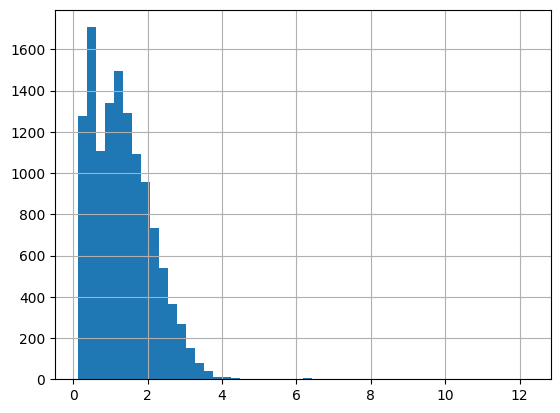

In [7]:
df["f_opt"].hist(bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x12c41a090>,
 'caps': [<matplotlib.lines.Line2D at 0x12c41a6c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12c3a02f0>],
 'medians': [<matplotlib.lines.Line2D at 0x12c41ac30>],
 'fliers': [<matplotlib.lines.Line2D at 0x12c41af30>],
 'means': []}

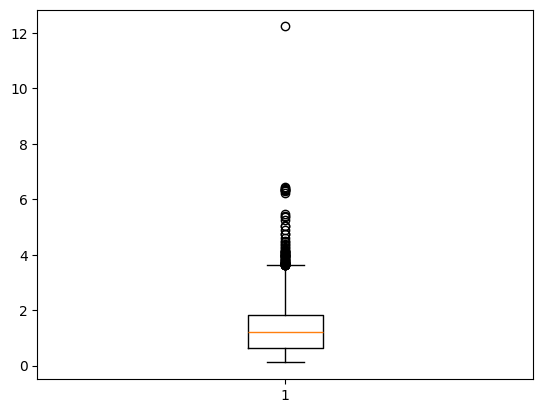

In [8]:
plt.boxplot(df["f_opt"])

In [9]:
df = df[df["f_opt"] < 10].reset_index(drop=True)

In [10]:
params_fitted = ["y_0", "B_z_0", "tau", "C_nm"]
n_params = len(params_fitted)
# Compute the errors
for param in params_fitted:
    df[param + "_error"] = df[param + "_opt"] - df[param]

df.head()

y_0       tau     C_nm     B_z_0   y_0_opt   tau_opt  C_nm_opt  \
0  0.304157  1.422337  1.68119  9.634234  0.303030  1.416800  1.655347   
1  0.304157  1.422337  1.68119  9.634234  0.304164  1.405207  1.740536   
2  0.304157  1.422337  1.68119  9.634234  0.302118  1.415865  1.682949   
3  0.304157  1.422337  1.68119  9.634234  0.303441  1.425672  1.654909   
4  0.304157  1.422337  1.68119  9.634234  0.305374  1.411861  1.703118   

   B_z_0_opt     f_opt  random_seed  noise_level  num_repeat  noise_level_abs  \
0   9.620309  0.137103            0     0.011505           0         0.110845   
1   9.710829  0.170507            1     0.011505           1         0.110845   
2   9.647078  0.180673            2     0.011505           2         0.110845   
3   9.630084  0.216997            3     0.011505           3         0.110845   
4   9.640283  0.203558            4     0.011505           4         0.110845   

   y_0_error  B_z_0_error  tau_error  C_nm_error  
0  -0.001127    -0.013924  -0.005537   -0.025843  
1   0.000007     0.076595  -0.017130    0.059346  
2  -0.002039     0.012845  -0.006472    0.001759  
3  -0.000717    -0.004150   0.003335   -0.026281  
4   0.001216     0.006049  -0.010476    0.021927

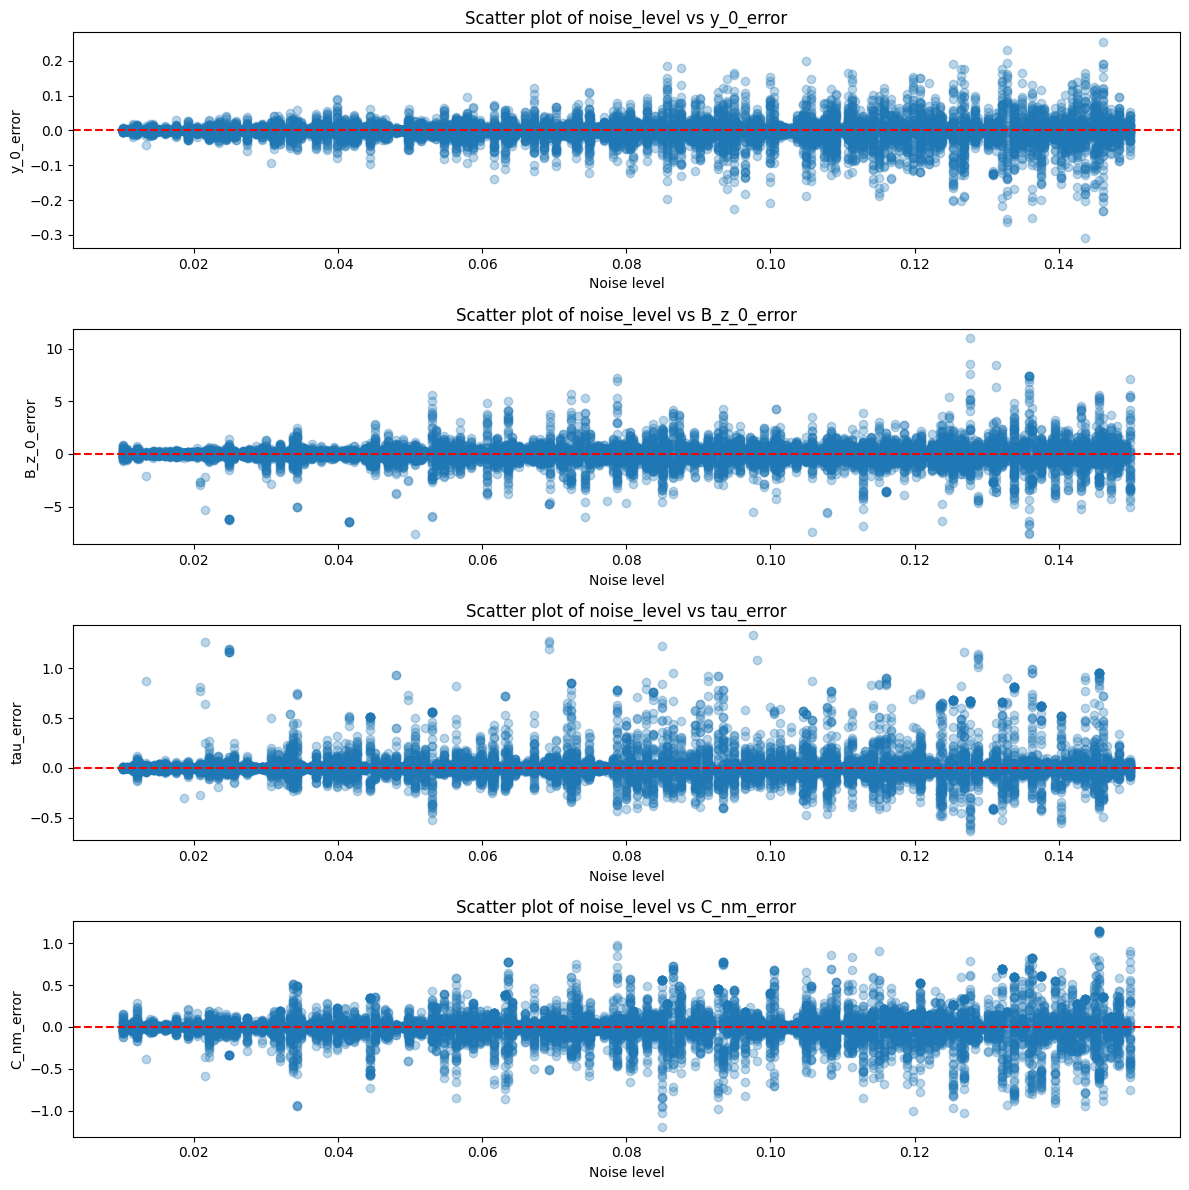

In [11]:
n_subplots = n_params

fig, axis = plt.subplots(n_subplots, 1, figsize=(12, 12), tight_layout=True)

plot_idx = 0
for i in range(n_params):
    ax = axis[plot_idx]
    param_i = params_fitted[i] + "_error"

    ax.scatter(df["noise_level"], df[param_i], alpha=0.3)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_xlabel("Noise level")
    ax.set_ylabel(param_i)
    ax.set_title(f"Scatter plot of noise_level vs {param_i}")

    plot_idx += 1
plt.show()

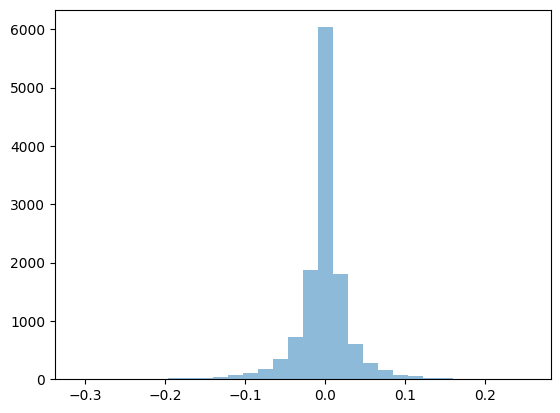

In [12]:
plt.hist(df["y_0_error"], bins=30, alpha=0.5, label="y_0_error")
plt.show()
plt.hist(df["B_z_0_error"], bins=30, alpha=0.5, label="B_z_0_error")
plt.show()
plt.hist(df["tau_error"], bins=30, alpha=0.5, label="tau_error")
plt.show()

# Find outliers by gating the "f_opt" variable

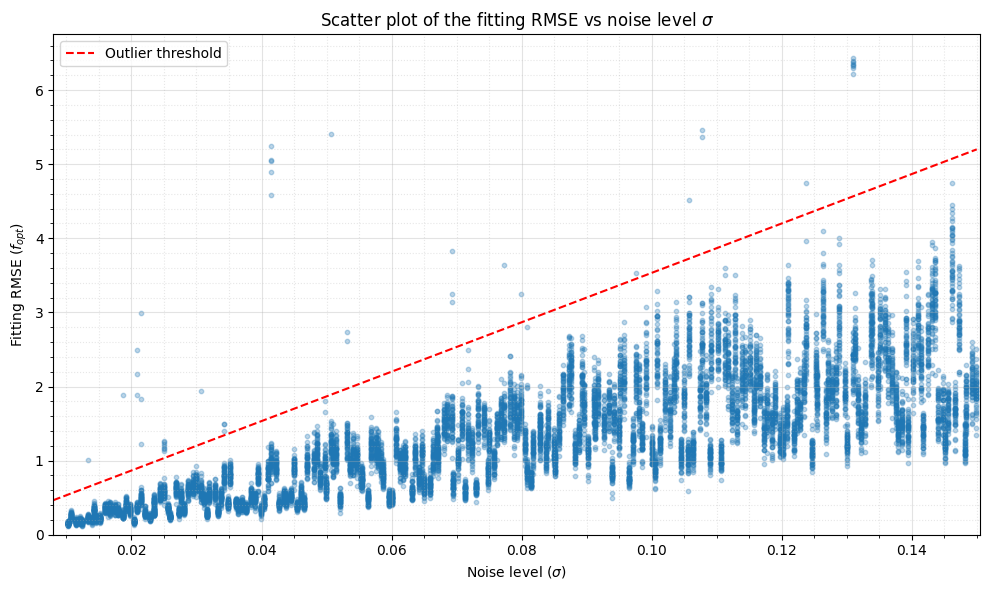

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
ax.scatter(df["noise_level"], df["f_opt"], alpha=0.3, s=10)
ax.set_xlabel(r"Noise level ($\sigma$)")
ax.set_ylabel(r"Fitting RMSE ($f_{opt}$)")
ax.plot([0, 0.15], [0.2, 5.2], c="r", linestyle="--", label="Outlier threshold")
ax.set_xlim(0.008, 0.1505)
ax.set_ylim(0)
ax = set_axis_grid_style(ax)
ax.legend()
ax.set_title(r"Scatter plot of the fitting RMSE vs noise level $\sigma$")
fig.savefig("f_opt_vs_noise_level.png", dpi=150, bbox_inches="tight")
plt.show()

In [14]:
outlier_mask = df["f_opt"] > 0.2 + ((5.2 - 0.2)/0.15)*df["noise_level"]

df = df[~outlier_mask].reset_index(drop=True)
print(f"After removing outliers, there are {len(df)} rows in the dataset")

After removing outliers, there are 12449 rows in the dataset


In [15]:
df_agg_num_repeat_count = df.groupby(params_fitted + ["noise_level"]).agg("count").reset_index()
df_agg_num_repeat_count["y_0_opt"].value_counts()

y_0_opt
50    227
49     13
47      4
48      3
45      1
42      1
43      1
Name: count, dtype: int64

In [16]:
first_experiment = df.iloc[:25]
first_experiment.head(1)

y_0       tau     C_nm     B_z_0  y_0_opt  tau_opt  C_nm_opt  \
0  0.304157  1.422337  1.68119  9.634234  0.30303   1.4168  1.655347   

   B_z_0_opt     f_opt  random_seed  noise_level  num_repeat  noise_level_abs  \
0   9.620309  0.137103            0     0.011505           0         0.110845   

   y_0_error  B_z_0_error  tau_error  C_nm_error  
0  -0.001127    -0.013924  -0.005537   -0.025843

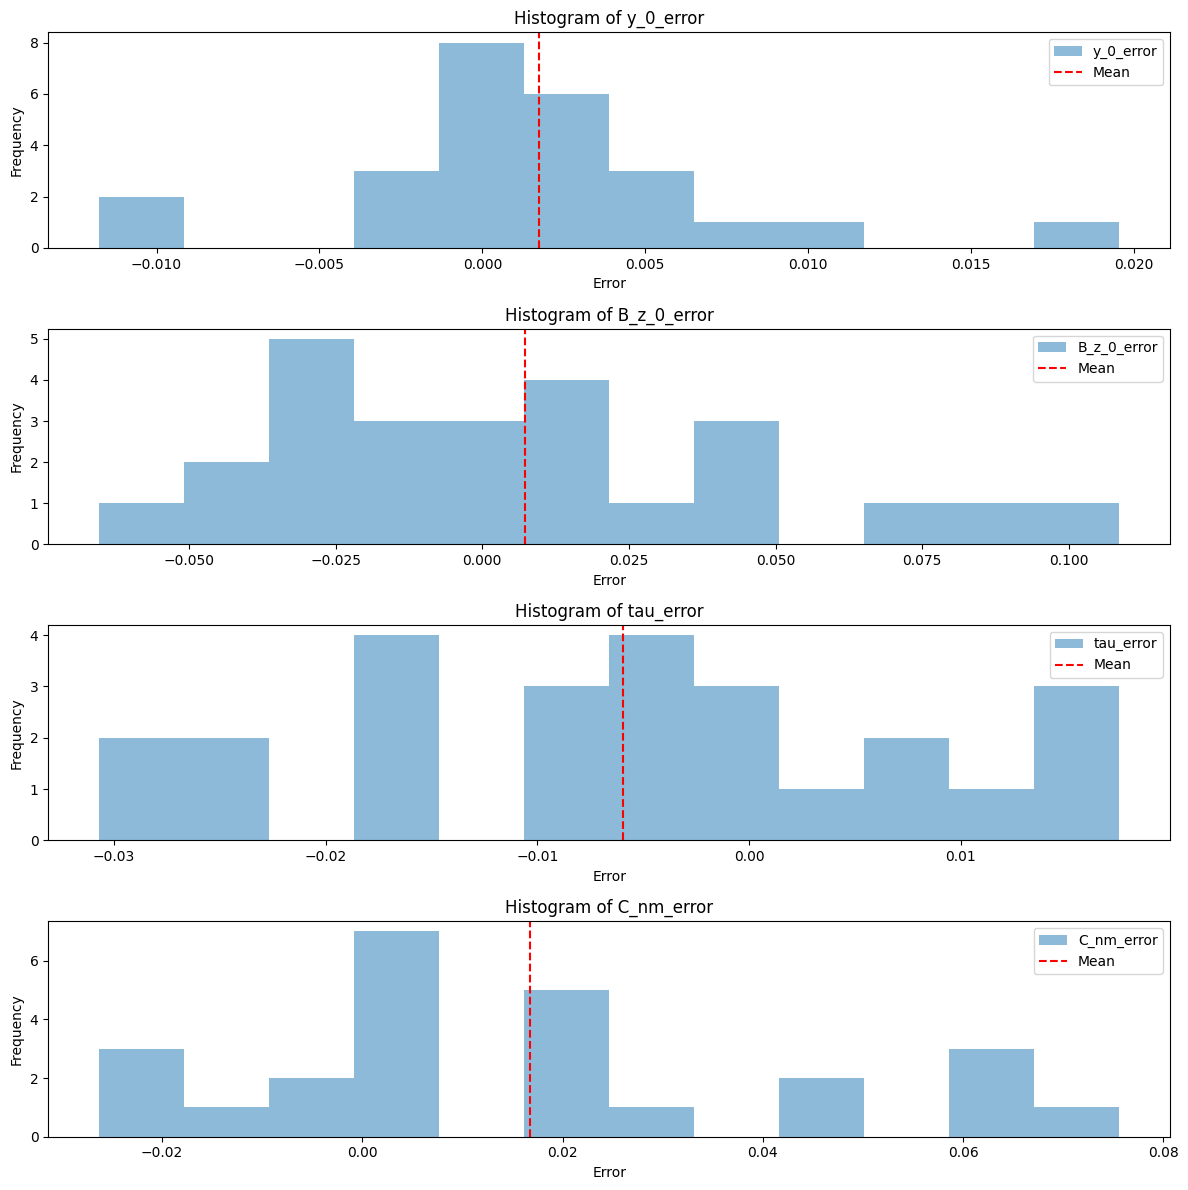

In [17]:
fig, ax = plt.subplots(len(params_fitted), 1, figsize=(12, 12), tight_layout=True)
for idx, param in enumerate(params_fitted):
    y = first_experiment[param + "_error"]
    y_mean = y.mean()
    ax[idx].hist(y, bins=12, alpha=0.5, label=param + "_error")
    ax[idx].axvline(y_mean, color="red", linestyle="--", label="Mean")
    ax[idx].set_title(f"Histogram of {param}_error")
    ax[idx].set_xlabel("Error")
    ax[idx].set_ylabel("Frequency")
    ax[idx].legend()
plt.show()

In [18]:
params_std = np.std(df[["y_0_error", "B_z_0_error", "tau_error"]].to_numpy(), ddof=1, axis=0)
params_std

array([0.034038  , 0.98287454, 0.15186656])

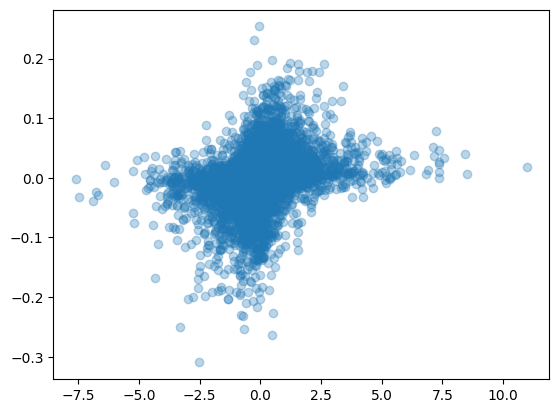

In [19]:
plt.scatter(df["B_z_0_error"], df["y_0_error"], alpha=0.3)

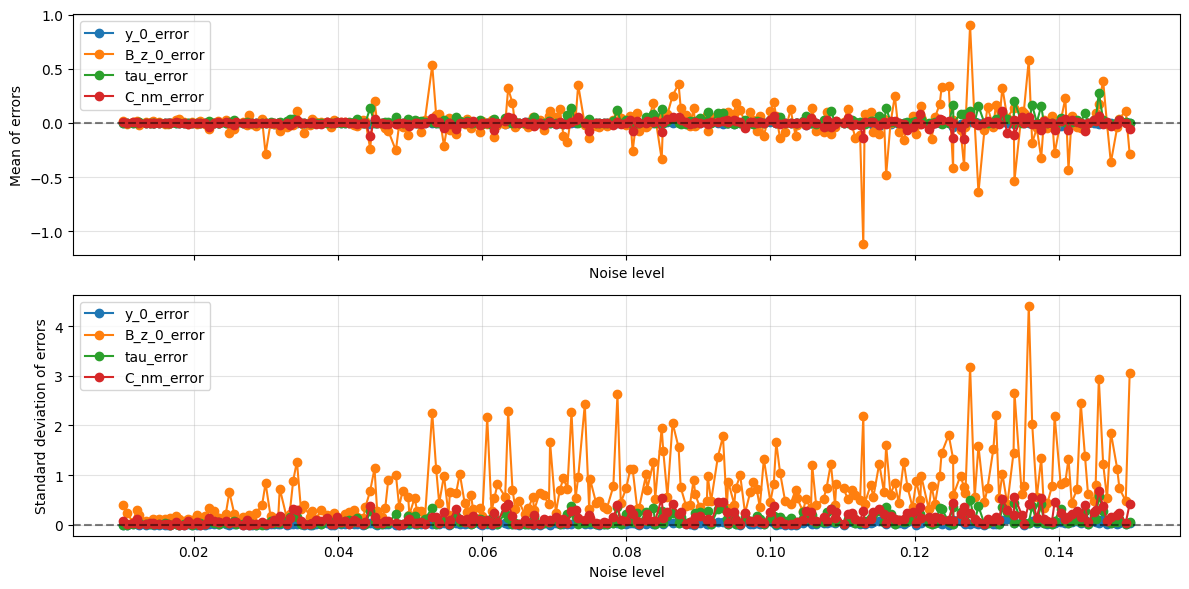

In [20]:
df_noise_agg_mean = df.groupby(params_fitted + ["noise_level"]).mean().sort_values("noise_level").reset_index()
df_noise_agg_std = df.groupby(params_fitted + ["noise_level"]).std().sort_values("noise_level").reset_index()

fig, axis = plt.subplots(2, 1, figsize=(12, 6), tight_layout=True, sharex=True)
for param in params_fitted:
    axis[0].plot(df_noise_agg_mean["noise_level"], df_noise_agg_mean[param + "_error"], "-o", label=param + "_error")
    axis[1].plot(df_noise_agg_std["noise_level"], df_noise_agg_std[param + "_error"], "-o", label=param + "_error")

for ax in axis:
    ax.axhline(0, color="k", linestyle="--", alpha=0.5)
    ax.legend()
    ax.set_xlabel("Noise level")
    ax.grid(alpha=0.35)

axis[0].set_ylabel("Mean of errors")
axis[1].set_ylabel("Standard deviation of errors")
plt.show()

In [21]:
df_agg_num_repeat_count = df.groupby(params_fitted + ["noise_level"]).agg("count").reset_index()
df_agg_num_repeat_count["y_0_opt"].value_counts()

y_0_opt
50    227
49     13
47      4
48      3
45      1
42      1
43      1
Name: count, dtype: int64

In [22]:
# def remove_iqr_outliers(group, cols):
#     for col in cols:
#         Q1 = group[col].quantile(0.25)
#         Q3 = group[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         group = group[(group[col] >= lower_bound) & (group[col] <= upper_bound)]
#     return group

# def quadratic_mean(series):
#     return np.sqrt(np.mean(series**2))


# columns_to_clean = [p + "_error" for p in params_fitted]  # replace with your actual column names
# df_cleaned = df.groupby(params_fitted + ["noise_level"], group_keys=False).apply(remove_iqr_outliers, cols=columns_to_clean)
# df_agg_num_repeat = df_cleaned.groupby(params_fitted + ["noise_level"]).agg(quadratic_mean).reset_index()
# df_agg_num_repeat

In [23]:
# df_clean_repeat_counts = df_cleaned.groupby(params_fitted + ["noise_level"]).agg("count").reset_index()
# df_clean_repeat_counts["y_0_opt"].value_counts()

In [24]:
# Method 1
df_agg_num_repeat = group_by_mean_squared(df, params_fitted + ["noise_level"])
df_agg_num_repeat

y_0      B_z_0       tau      C_nm  noise_level   y_0_opt   tau_opt  \
0    0.002648  11.156091  1.535639  0.101969     0.020836  0.002905  1.531326   
1    0.005175   9.432106  1.885285  0.198009     0.061300  0.006901  1.871245   
2    0.010211  10.197377  0.395038  1.050270     0.019718  0.011036  0.395100   
3    0.013062   7.019020  0.870404  0.618327     0.146701  0.023508  0.871457   
4    0.017415  13.006961  0.914066  0.839968     0.016395  0.017645  0.914304   
..        ...        ...       ...       ...          ...       ...       ...   
245  0.883282   8.370417  1.282168  1.536826     0.084908  0.882637  1.434519   
246  0.885799   9.000304  1.830231  0.327677     0.127697  0.890029  1.998964   
247  0.889901   5.974933  0.304956  1.119898     0.069423  0.890254  0.309432   
248  0.895274  14.450156  1.937065  0.469671     0.053071  0.894703  1.970998   
249  0.897975   6.885537  1.545040  0.951795     0.145556  0.888215  1.907389   

     C_nm_opt  B_z_0_opt     f_opt   random_seed  num_repeat  noise_level_abs  \
0    0.102536  11.174658  0.369870   2474.765186   28.601443         0.232444   
1    0.203107   9.460337  0.966075   4374.523803   28.434134         0.578184   
2    1.050459  10.204631  0.337771   2924.535604   28.434134         0.201076   
3    0.626795   7.024839  1.679744   6474.516082   28.434134         1.029697   
4    0.839736  12.995583  0.356456  11074.509402   28.434134         0.213253   
..        ...        ...       ...           ...         ...              ...   
245  1.541412   8.262946  1.163177  12074.508624   28.434134         0.710712   
246  0.459801  10.388899  1.956097   5374.519374   28.434134         1.149313   
247  1.129731   6.306437  0.687521   4724.522039   28.434134         0.414795   
248  0.534916  15.146778  1.270729   5074.270990   28.303416         0.766887   
249  1.220927   7.639574  1.689560   6124.517001   28.434134         1.002234   

     y_0_error  B_z_0_error  tau_error  C_nm_error  
0     0.000822     0.084737   0.029650    0.002537  
1     0.005673     0.268030   0.128897    0.017661  
2     0.002665     0.098307   0.002205    0.007568  
3     0.022321     0.527013   0.069346    0.074432  
4     0.002512     0.090355   0.009138    0.013248  
..         ...          ...        ...         ...  
245   0.028481     1.957379   0.310306    0.533052  
246   0.014375     3.275169   0.507986    0.244459  
247   0.004448     1.647305   0.058790    0.105780  
248   0.008633     2.296718   0.333234    0.162817  
249   0.040007     2.914972   0.629945    0.679657  

[250 rows x 17 columns]

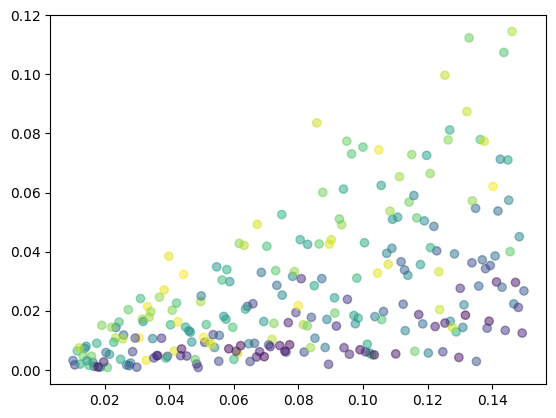

In [25]:
plt.scatter(df_agg_num_repeat["noise_level"], df_agg_num_repeat["y_0_error"], c=df_agg_num_repeat["tau"], alpha=0.5)

In [26]:
0.189/0.0554

3.411552346570397

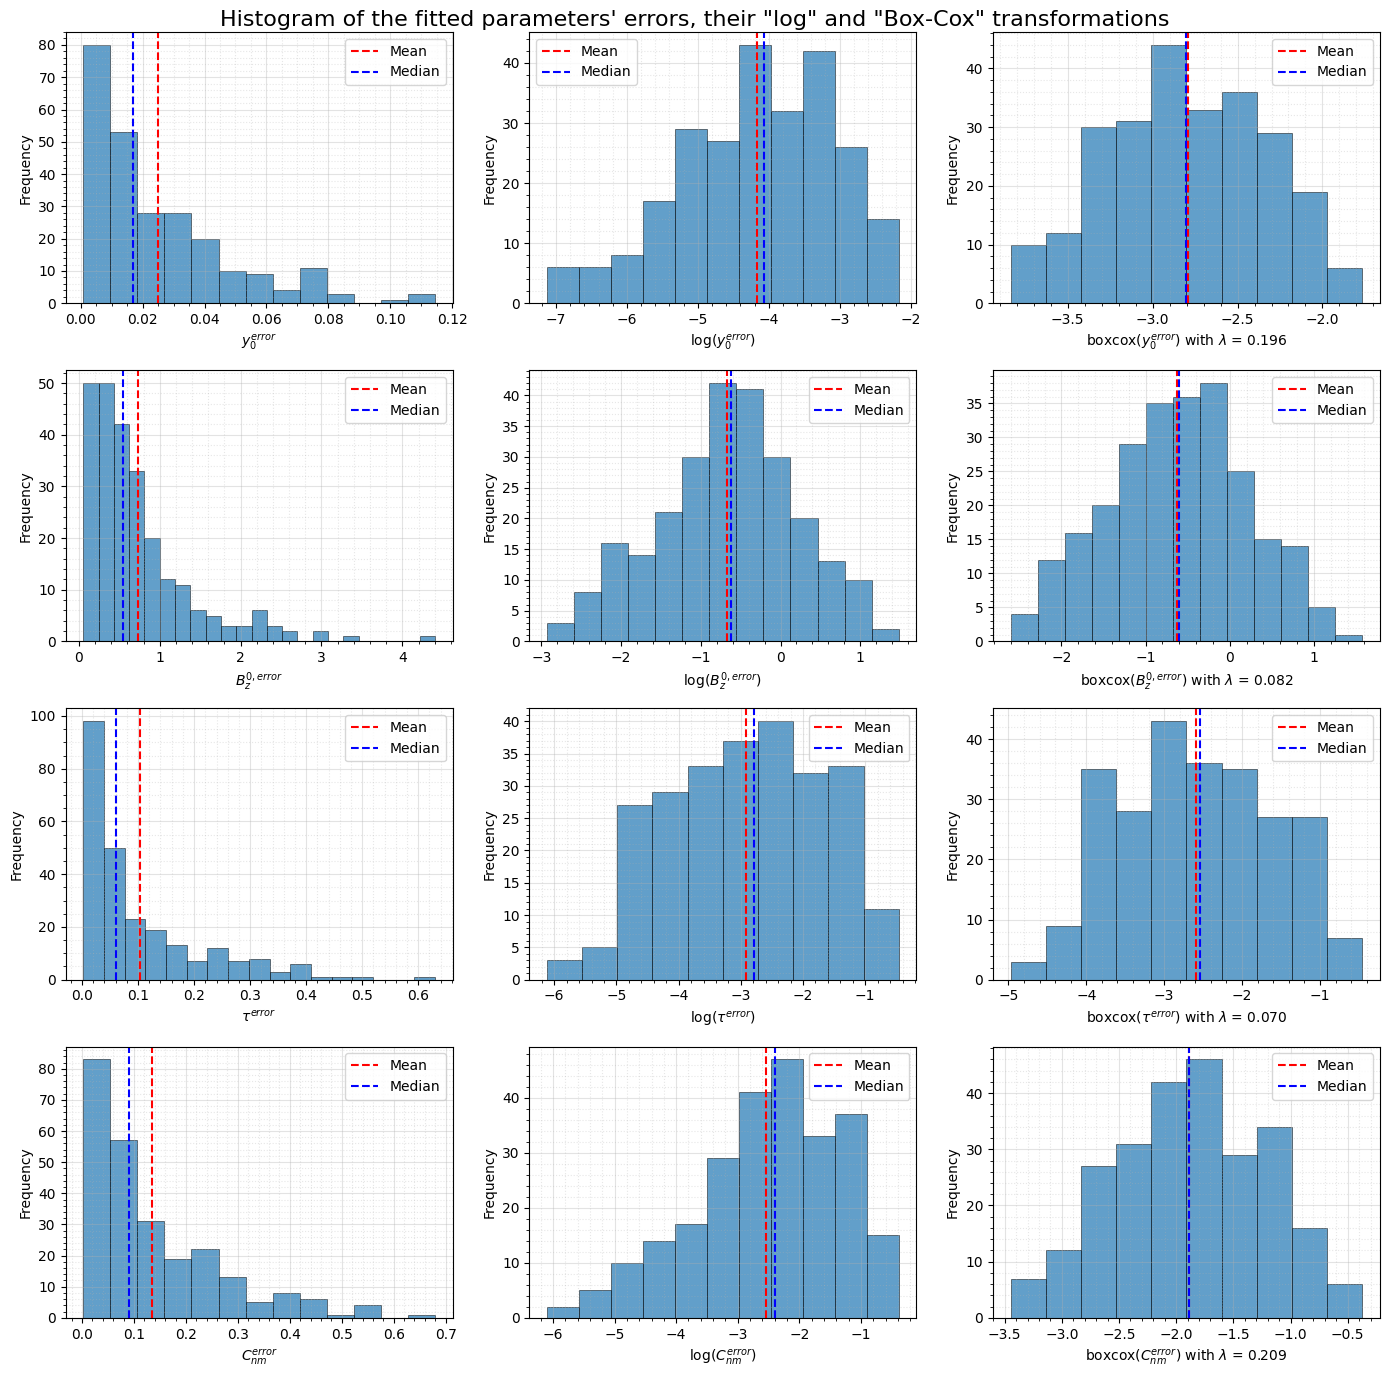

In [27]:
plot_histogram(df_agg_num_repeat, params_fitted, label_mapping, save_filepath="histogram_fitted_params_errors.png", dpi=100)

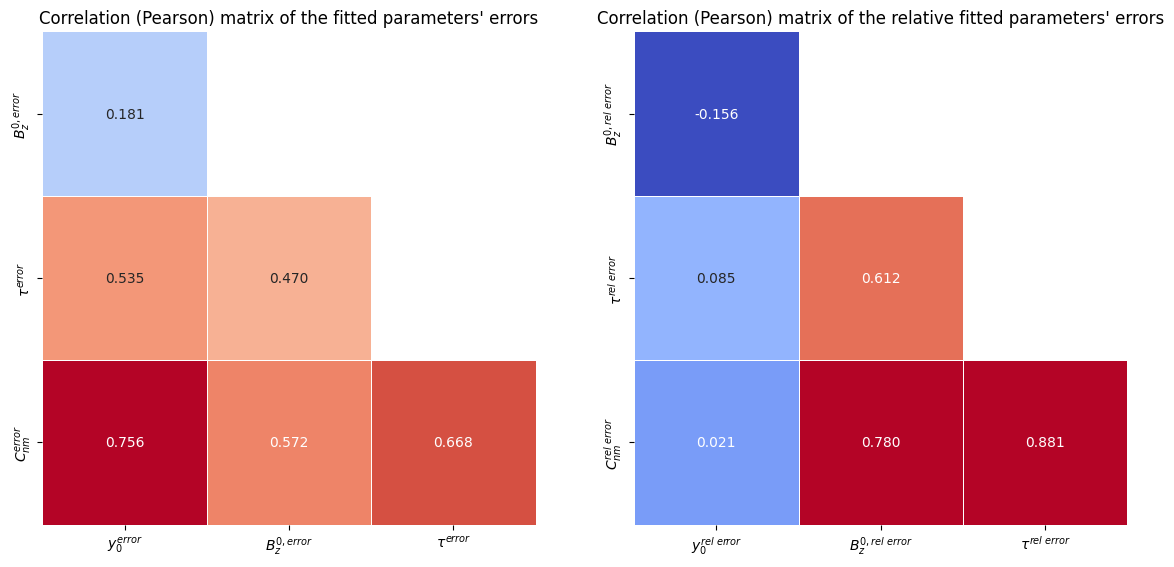

In [28]:
for p in params_fitted:
        df_agg_num_repeat[p + "_rel_error"] = (df_agg_num_repeat[p + "_error"]  / df_agg_num_repeat[p]) * 100

plot_target_error_and_relative_correlations(df_agg_num_repeat, params_fitted, label_mapping, save_file_name="correlation_matrix_fitted_params_errors.png")

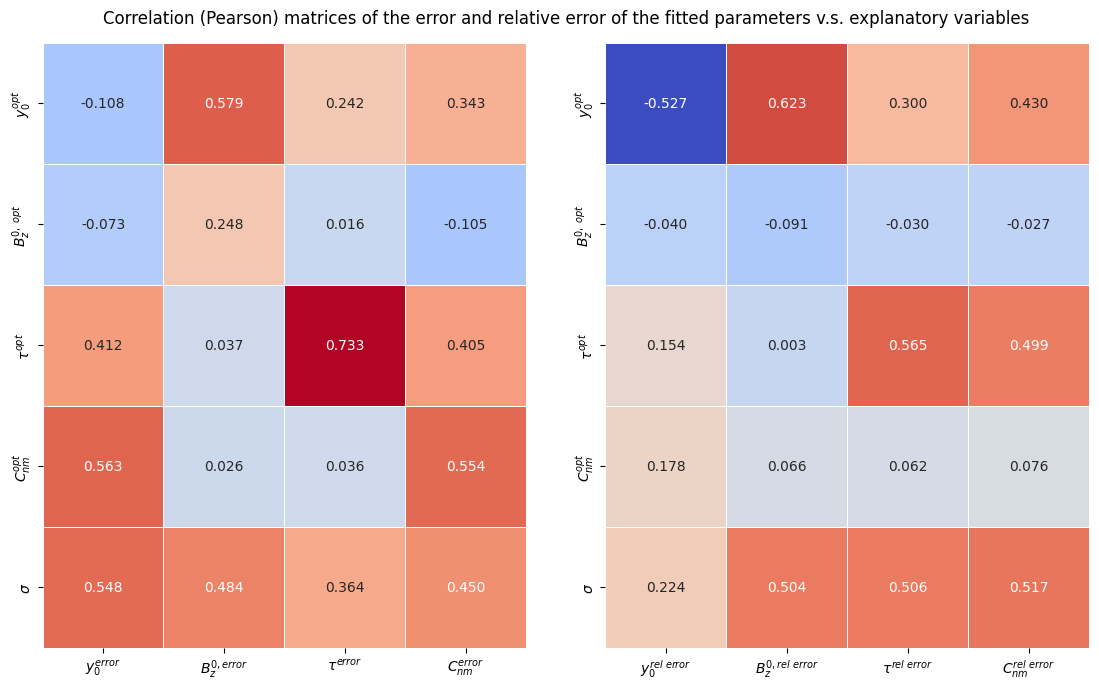

In [29]:
plot_target_error_and_relative_vs_features_correlations(df_agg_num_repeat, params_fitted, label_mapping, save_file_name="correlation_matrix_fitted_params_errors_vs_explanatory.png")

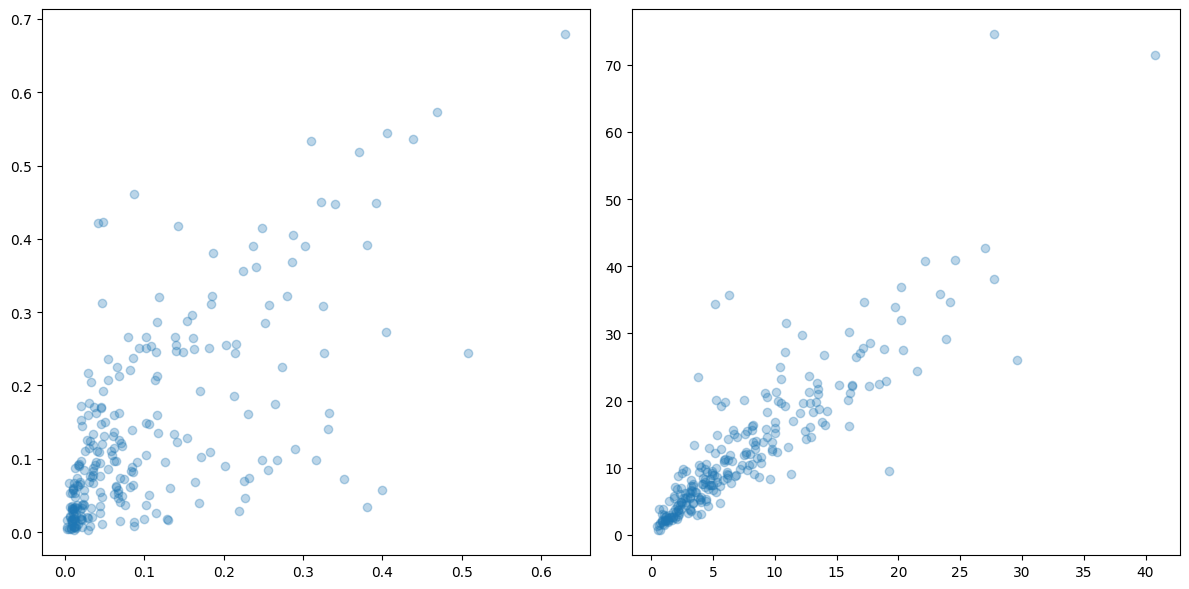

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
ax[0].scatter(df_agg_num_repeat["tau_error"], df_agg_num_repeat["C_nm_error"], alpha=0.3)
ax[1].scatter(df_agg_num_repeat["tau_rel_error"], df_agg_num_repeat["C_nm_rel_error"], alpha=0.3)

In [31]:
print(f"Size of the dataset: {len(df_agg_num_repeat)}")

Size of the dataset: 250


# Train a metamodel

In [32]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# Define the model type and transformation type
model_type = "linear" # "linear" #"ridge", "gpr"
transform_type = "box-cox" #"log" # "log" #"log" # "log"
outlier_detection = "IQR+"

targets = [p + suffix for p in params_fitted for suffix in ["_error", "_rel_error"]]

models = {}
for param_error_name in targets:
    print(f"Fitting model for {param_error_name}...")
    models[param_error_name] = fit_regression_model(df=df_agg_num_repeat,
                                                    params_fitted=params_fitted,
                                                    target_name=param_error_name,
                                                    model_type=model_type,
                                                    transform_type=transform_type,
                                                    outlier_detection=outlier_detection,
                                                    verbose=False)

Fitting model for y_0_error...
Removing 9 outliers using IQR+ method with y_0_error > 0.0776
Fitting model for y_0_rel_error...
Removing 37 outliers using IQR+ method with y_0_rel_error > 23.8924
Fitting model for B_z_0_error...
Removing 20 outliers using IQR+ method with B_z_0_error > 1.8179
Fitting model for B_z_0_rel_error...
Removing 18 outliers using IQR+ method with B_z_0_rel_error > 18.1823
Fitting model for tau_error...
Removing 18 outliers using IQR+ method with tau_error > 0.3211
Fitting model for tau_rel_error...
Removing 11 outliers using IQR+ method with tau_rel_error > 20.9820
Fitting model for C_nm_error...
Removing 8 outliers using IQR+ method with C_nm_error > 0.4505
Fitting model for C_nm_rel_error...
Removing 12 outliers using IQR+ method with C_nm_rel_error > 34.2480


In [33]:
models["y_0_error"]["stats"]

RMSE       R^2
Train  0.003823  0.956532
Test   0.003716  0.966963
All    0.003791  0.960198

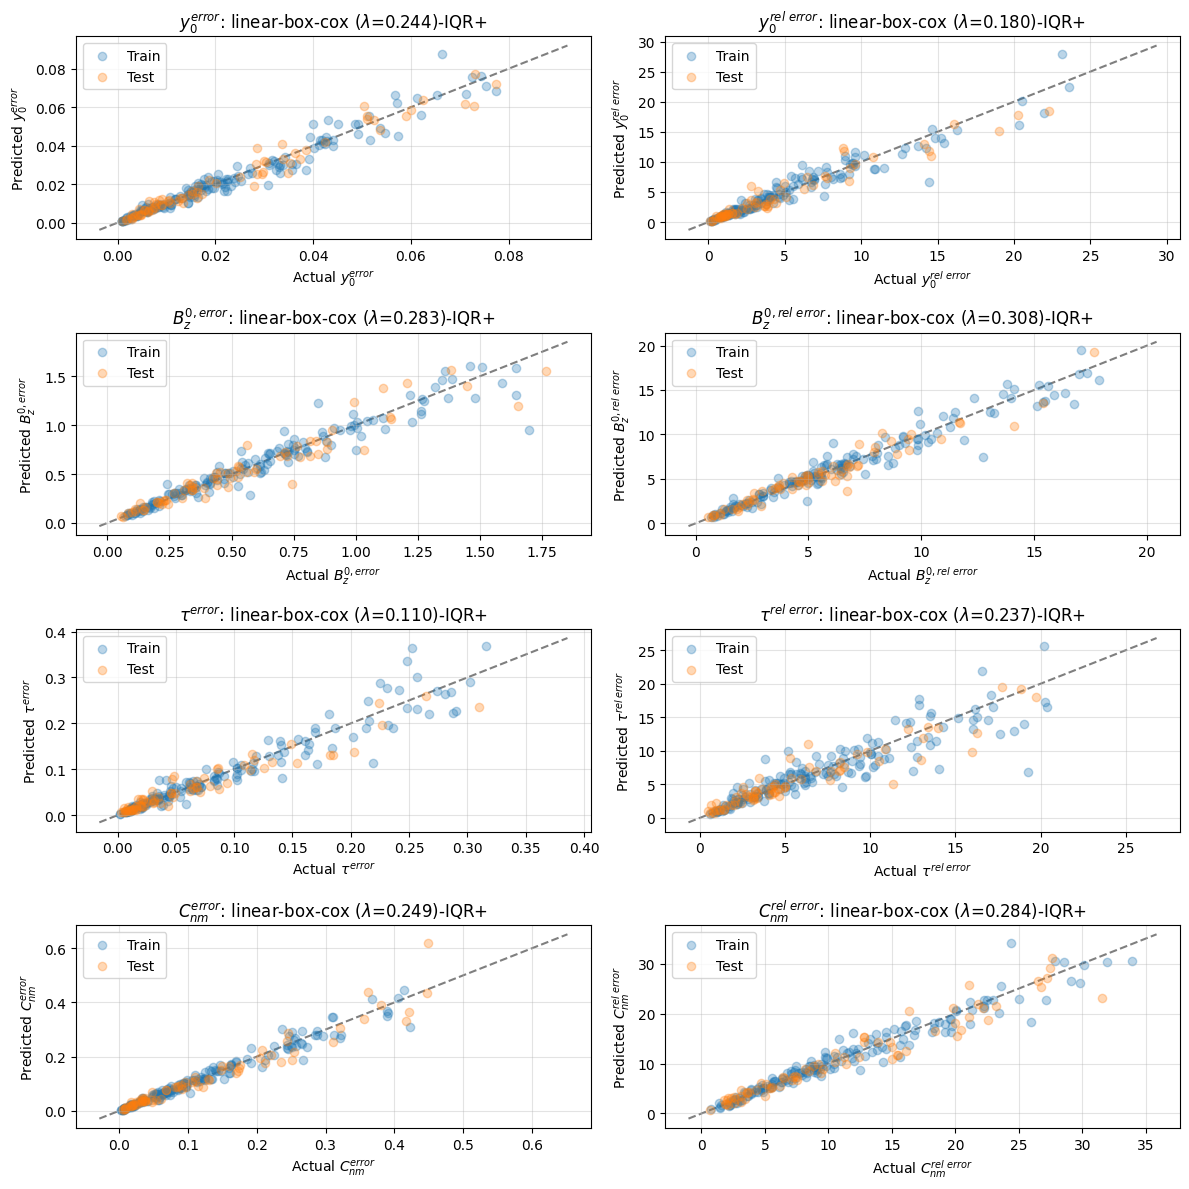

In [34]:
plot_model_results(models, save_file_name="cc_model_results.png")

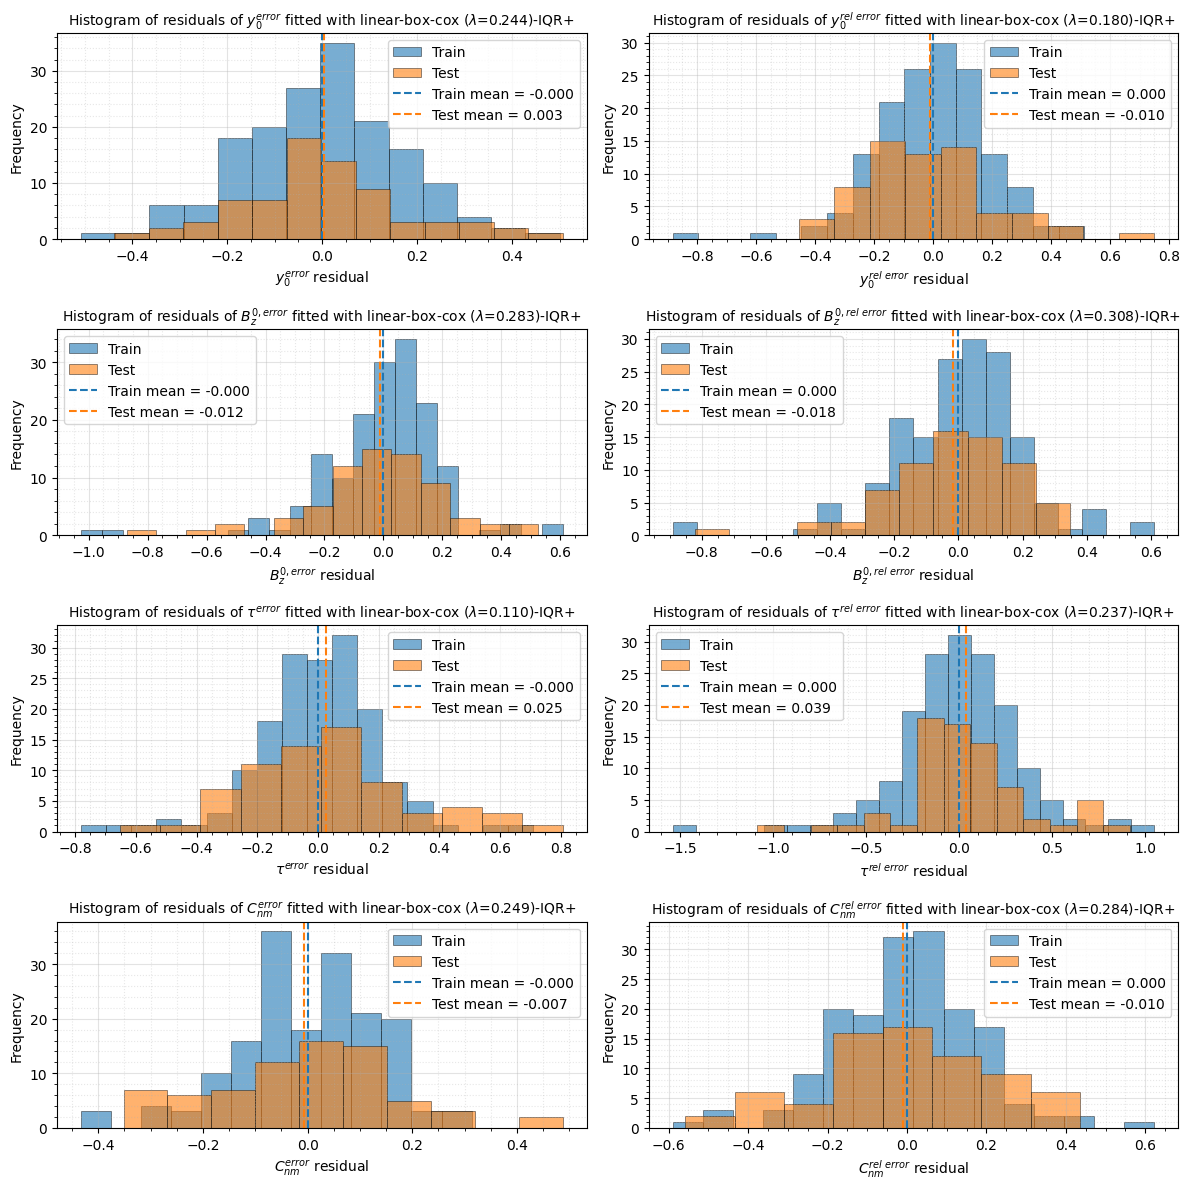

In [35]:
plot_residuals(models, method="histogram", save_file_path="residuals_histogram.png")
#plot_residuals(models, method="Q-Q")

In [36]:
models["y_0_error"]["y_test"]

array([ 1.80596463,  0.21249227,  1.93269538, -0.74795075,  0.6006618 ,
        0.65218874,  1.33871106,  0.59530787, -1.47297326, -0.02184669,
       -0.28099301,  0.67870347, -0.70017653, -1.31808201, -0.87215554,
        0.89208974, -1.47761421, -1.19967462,  1.4096241 ,  1.84260559,
       -1.09937695,  1.33602016, -0.58188085, -1.00788587, -0.43386971,
        0.64585316, -1.45859981, -0.45955046, -1.38536766, -0.08027151,
       -0.21370861, -0.13470691,  0.92681709,  1.6185808 , -1.81956967,
       -0.90799595, -0.08052055,  0.8074659 , -0.58206839, -1.15664876,
       -0.59732266, -0.01484982,  1.53887075,  1.84781529, -0.25805681,
       -0.73166493, -0.42291409, -0.63322294, -0.96512802,  0.65678116,
       -1.71976805, -0.73713569,  1.09448333,  0.45122312,  0.96768082,
       -0.00473113, -2.12088235,  0.84453614,  0.60554318, -0.88115706,
       -0.78174168, -1.13823776,  1.32203711,  0.7980183 , -0.22332294,
       -1.09692087,  0.04105481,  0.13016809,  0.57925052, -0.90

In [37]:
# Set the significance level
alpha = 0.05
df_shapiro_wilk = []

# Perform the Shapiro-Wilk test for normality on the residuals of each model
for target, model_result in models.items():
    stat, p_value = stats.shapiro(model_result["train_residuals"])
    df_shapiro_wilk.append({
        "target": target,
        "stat": stat,
        "p_value": p_value,
        "normal": p_value > alpha,
    })
    
df_shapiro_wilk = pd.DataFrame(df_shapiro_wilk)
df_shapiro_wilk

target      stat       p_value  normal
0        y_0_error  0.997045  9.865232e-01    True
1    y_0_rel_error  0.967619  1.380789e-03   False
2      B_z_0_error  0.892339  1.927397e-09   False
3  B_z_0_rel_error  0.940061  2.423791e-06   False
4        tau_error  0.963354  2.788998e-04   False
5    tau_rel_error  0.958994  8.071820e-05   False
6       C_nm_error  0.978064  8.860371e-03   False
7   C_nm_rel_error  0.981997  2.980101e-02   False

In [38]:
get_models_stats(models).style.background_gradient(cmap="coolwarm", axis=None)

In [39]:
1-2.16/3

0.2799999999999999

In [40]:
1-1.43/1.9

0.24736842105263157

In [41]:
4.24/3.69

1.1490514905149052

# Do a sweep of all the models

In [64]:
all_models = {}

for model_type in ["linear", "ridge", "gpr"]:
    all_models[model_type] = {}
    for transform_type in ["box-cox"]:
        all_models[model_type][transform_type] = {}
        for outlier_detection in [None, "IQR+"]:
            all_models[model_type][transform_type][outlier_detection] = {}
            for target in targets:
                all_models[model_type][transform_type][outlier_detection][target] = {}
                print(f"-> Fitting model for {target}...")
                models = fit_regression_model(df=df_agg_num_repeat,
                                            params_fitted=params_fitted,
                                            target_name=target,
                                            model_type=model_type,
                                            transform_type=transform_type,
                                            outlier_detection=outlier_detection,
                                            verbose=False)
                all_models[model_type][transform_type][outlier_detection][target] =  models

-> Fitting model for y_0_error...
No outliers removed using None method
-> Fitting model for y_0_rel_error...
No outliers removed using None method
-> Fitting model for B_z_0_error...
No outliers removed using None method
-> Fitting model for B_z_0_rel_error...
No outliers removed using None method
-> Fitting model for tau_error...
No outliers removed using None method
-> Fitting model for tau_rel_error...
No outliers removed using None method
-> Fitting model for C_nm_error...
No outliers removed using None method
-> Fitting model for C_nm_rel_error...
No outliers removed using None method
-> Fitting model for y_0_error...
Removing 9 outliers using IQR+ method with y_0_error > 0.0776
-> Fitting model for y_0_rel_error...
Removing 37 outliers using IQR+ method with y_0_rel_error > 23.8924
-> Fitting model for B_z_0_error...
Removing 20 outliers using IQR+ method with B_z_0_error > 1.8179
-> Fitting model for B_z_0_rel_error...
Removing 18 outliers using IQR+ method with B_z_0_rel_error

/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasi

Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=1)}
Best cross-validated RMSE: 0.18888623738720528
-> Fitting model for y_0_rel_error...
No outliers removed using None method


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Best parameters: {'alpha': 0.1, 'kernel': RBF(length_scale=0.5)}
Best cross-validated RMSE: 0.31530604525623546
-> Fitting model for B_z_0_error...
No outliers removed using None method


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=0.5)}
Best cross-validated RMSE: 0.23413743477785204
-> Fitting model for B_z_0_rel_error...
No outliers removed using None method


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=0.1)}
Best cross-validated RMSE: 0.24372815730741162
-> Fitting model for tau_error...
No outliers removed using None method


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=1)}
Best cross-validated RMSE: 0.19109069264562759
-> Fitting model for tau_rel_error...
No outliers removed using None method


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=0.5)}
Best cross-validated RMSE: 0.29052005926236635
-> Fitting model for C_nm_error...
No outliers removed using None method


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH

Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=5)}
Best cross-validated RMSE: 0.14742665702306465
-> Fitting model for C_nm_rel_error...
No outliers removed using None method


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=0.5)}
Best cross-validated RMSE: 0.21668714716668977
-> Fitting model for y_0_error...
Removing 9 outliers using IQR+ method with y_0_error > 0.0776


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Best parameters: {'alpha': 0.1, 'kernel': RBF(length_scale=0.1)}
Best cross-validated RMSE: 0.2160972733828098
-> Fitting model for y_0_rel_error...
Removing 37 outliers using IQR+ method with y_0_rel_error > 23.8924
Best parameters: {'alpha': 0.1, 'kernel': RBF(length_scale=5)}
Best cross-validated RMSE: 0.2556844560692974
-> Fitting model for B_z_0_error...
Removing 20 outliers using IQR+ method with B_z_0_error > 1.8179


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Best parameters: {'alpha': 0.1, 'kernel': RBF(length_scale=1)}
Best cross-validated RMSE: 0.27500108420213737
-> Fitting model for B_z_0_rel_error...
Removing 18 outliers using IQR+ method with B_z_0_rel_error > 18.1823


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better v

Best parameters: {'alpha': 0.1, 'kernel': RBF(length_scale=5)}
Best cross-validated RMSE: 0.2873052121187809
-> Fitting model for tau_error...
Removing 18 outliers using IQR+ method with tau_error > 0.3211


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=0.1)}
Best cross-validated RMSE: 0.21882324336428075
-> Fitting model for tau_rel_error...
Removing 11 outliers using IQR+ method with tau_rel_error > 20.9820


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better v

Best parameters: {'alpha': 0.1, 'kernel': RBF(length_scale=0.5)}
Best cross-validated RMSE: 0.33396625046252554
-> Fitting model for C_nm_error...
Removing 8 outliers using IQR+ method with C_nm_error > 0.4505


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=0.5)}
Best cross-validated RMSE: 0.1556770056028147
-> Fitting model for C_nm_rel_error...
Removing 12 outliers using IQR+ method with C_nm_rel_error > 34.2480


/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or sca

Best parameters: {'alpha': 0.01, 'kernel': RBF(length_scale=5)}
Best cross-validated RMSE: 0.23576903577473504


In [66]:
def get_all_target_stats(all_models: dict, targets: list) -> dict:
    models_stats = {}
    for target in targets:
        this_r2 = []
        this_rmse = []
        this_columns = []
        models_stats[target] = {}
        for model_type in all_models.keys():
            for transform_type in all_models[model_type].keys():
                for outlier_detection in all_models[model_type][transform_type].keys():
                    this_r2.append(all_models[model_type][transform_type][outlier_detection][target]["stats"]["R^2"].values)
                    this_rmse.append(all_models[model_type][transform_type][outlier_detection][target]["stats"]["RMSE"].values)
                    this_columns.append(all_models[model_type][transform_type][outlier_detection][target]["model_label"])
        models_stats[target] = pd.DataFrame(np.hstack([this_r2, this_rmse]), columns=["R^2 Train", "R^2 Test", "R^2 Overall", "RMSE Train", "RMSE Test", "RMSE Overall"], index=this_columns)

    return models_stats

all_stats = get_all_target_stats(all_models, targets)

In [67]:
all_stats["y_0_error"].style.background_gradient(cmap="coolwarm", axis=None)

In [68]:
all_stats["y_0_rel_error"].style.background_gradient(cmap="coolwarm", axis=None)

In [69]:
all_stats["B_z_0_error"].style.background_gradient(cmap="coolwarm", axis=None)

In [70]:
all_stats["B_z_0_rel_error"].style.background_gradient(cmap="coolwarm", axis=None)

In [71]:
all_stats["tau_error"].style.background_gradient(cmap="coolwarm", axis=None)

In [72]:
all_stats["tau_rel_error"].style.background_gradient(cmap="coolwarm", axis=None)

In [75]:
all_stats["tau_rel_error"].to_clipboard()

In [73]:
all_stats["C_nm_error"].style.background_gradient(cmap="coolwarm", axis=None)

In [74]:
all_stats["C_nm_rel_error"].style.background_gradient(cmap="coolwarm", axis=None)

In [ ]:
all_models["gpr"]["box-cox"]["IQR+"]["C_nm_error"]["model"].kernel_.length_scale

np.float64(2.8458670087114397)

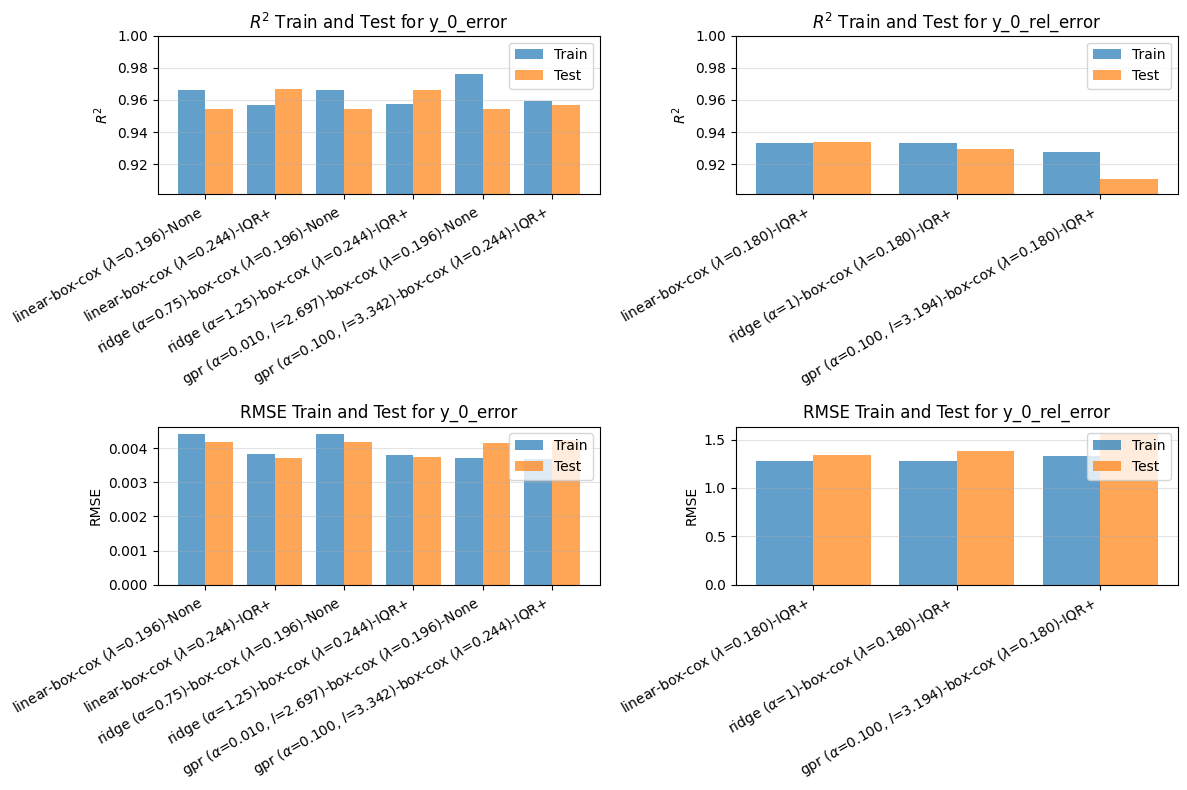

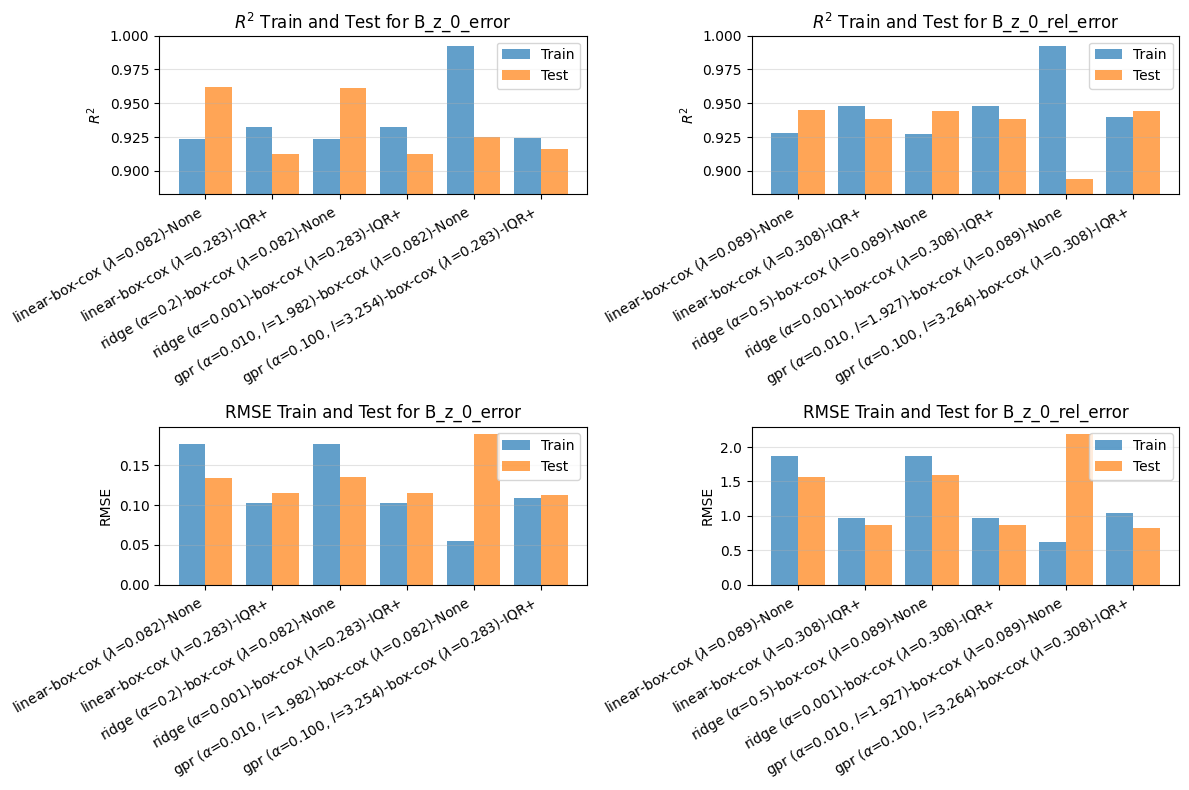

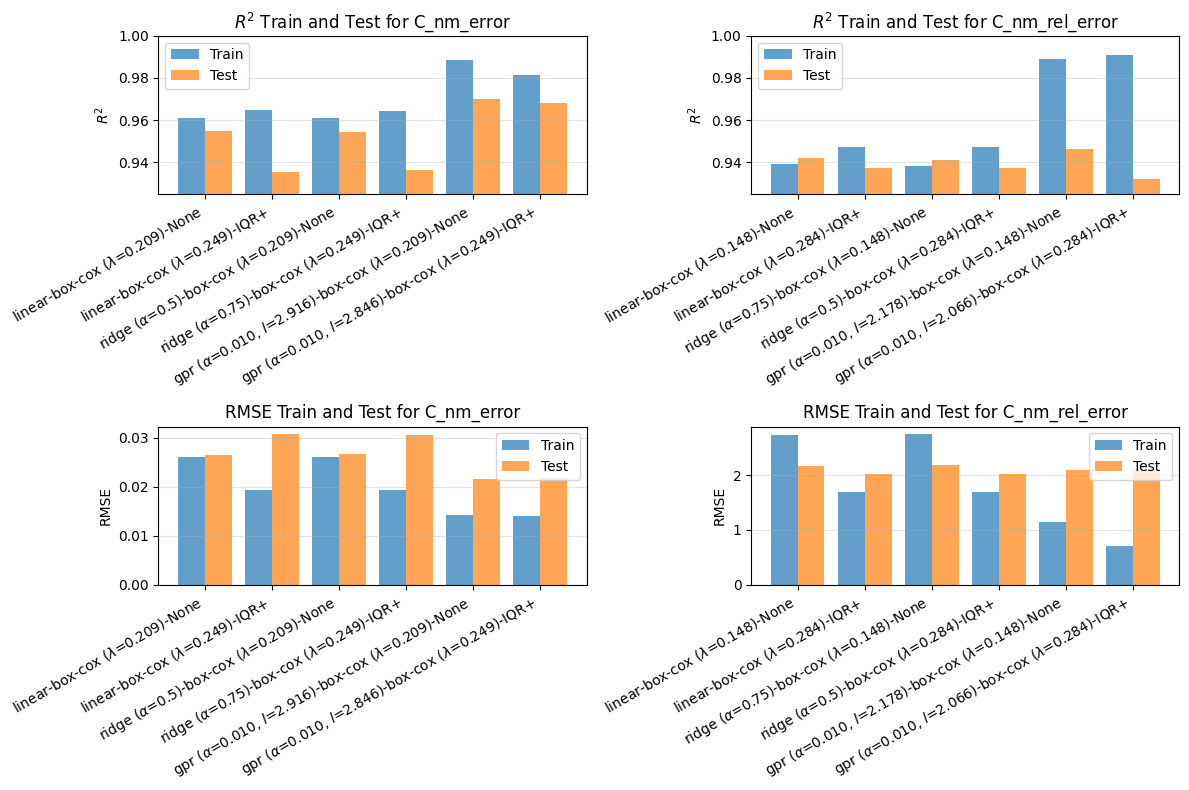

In [ ]:
for target in targets:
    if "_rel_error" in target:
        continue
    
    r2_theshold = 0.7
    fig, axis = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
    target_rel_error = target.replace("_error", "_rel_error")

    # Filter out bad models
    stats_dfs = {}
    for this_target, ax in zip([target, target_rel_error], axis.T):
        this_df_stats = all_stats[this_target]
        this_df_stats = this_df_stats[np.all(this_df_stats[["R^2 Train", "R^2 Test"]].to_numpy() > r2_theshold, axis=1)]
        stats_dfs[this_target] = this_df_stats

    # Get the minimum R^2 value for the target and its relative error to set the y limits
    min_r2_target = stats_dfs[target][["R^2 Train", "R^2 Test"]].min().min()
    min_r2_target_rel = stats_dfs[target_rel_error][["R^2 Train", "R^2 Test"]].min().min()
    min_r2 = min(min_r2_target, min_r2_target_rel)

    for (this_target, this_df_stats), ax in zip(stats_dfs.items(), axis.T):
        # Bar width for grouped bars
        bar_width = 0.4
        x = np.arange(len(this_df_stats))

        # Plot Train and Test R^2
        ax[0].bar(x - bar_width / 2, this_df_stats["R^2 Train"], bar_width, alpha=0.7, label="Train")
        ax[0].bar(x + bar_width / 2, this_df_stats["R^2 Test"], bar_width, alpha=0.7, label="Test")
        ax[0].set_ylim(min_r2 - 0.1*(1-min_r2), 1)
        ax[0].set_ylabel("$R^2$")
        ax[0].set_title(f"$R^2$ Train and Test for {this_target}")

        # Plot Train and Test RMSE
        ax[1].bar(x - bar_width / 2, this_df_stats["RMSE Train"], bar_width, alpha=0.7, label="Train")
        ax[1].bar(x + bar_width / 2, this_df_stats["RMSE Test"], bar_width, alpha=0.7, label="Test")
        ax[1].set_ylabel("RMSE")
        ax[1].set_title(f"RMSE Train and Test for {this_target}")

        for ax_idx in [0, 1]:
            ax[ax_idx].set_xticks(x)
            ax[ax_idx].set_xticklabels(this_df_stats.index, rotation=30, ha="right")
            ax[ax_idx].grid(axis="y", alpha=0.35)
            ax[ax_idx].legend()
        
    plt.show()

# Polynomial v.s. ridge regularisation investigation

In [ ]:
all_models["linear"]["box-cox"][None]["y_0_error"]["model"].intercept_

np.float64(0.5316814846590604)

<BarContainer object of 20 artists>

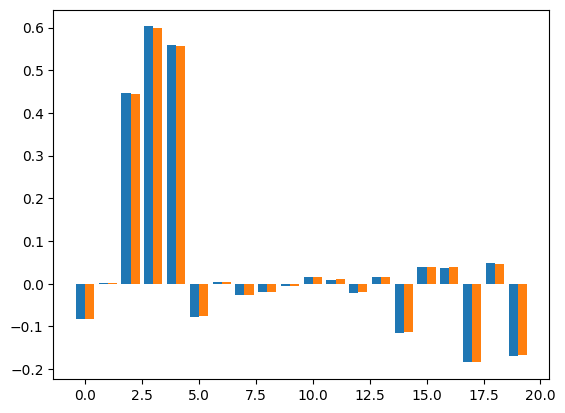

In [ ]:
non_ridge_coefficients = all_models["linear"]["box-cox"][None]["y_0_error"]["model"].coef_
ridge_coefficients = all_models["ridge"]["box-cox"][None]["y_0_error"]["model"].coef_
x = np.arange(len(non_ridge_coefficients))
bar_width = 0.4
plt.bar(x - bar_width/2, non_ridge_coefficients, width=0.4, label="Non-Ridge")
plt.bar(x + bar_width/2, ridge_coefficients, width=0.4, label="Ridge")

In [ ]:
polynomial_coefficients = {}

for param in params_fitted:
    non_ridge = all_models["linear"]["box-cox"]["IQR+"][param + "_error"]["model"].coef_ + all_models["linear"]["box-cox"]["IQR+"][param + "_error"]["model"].intercept_
    ridge = all_models["ridge"]["box-cox"]["IQR+"][param + "_error"]["model"].coef_ + all_models["ridge"]["box-cox"]["IQR+"][param + "_error"]["model"].intercept_
    polynomial_coefficients[param + "_error"] = {
        "non_ridge": non_ridge,
        "ridge": ridge,
    }

array([0.4544125 , 0.52899435, 1.01044399, 1.17362459, 1.13470582,
       0.4707714 , 0.53270233, 0.5083114 , 0.5254177 , 0.51848152,
       0.55828653, 0.54092768, 0.49893121, 0.54538522, 0.41641919,
       0.58521137, 0.56899277, 0.35010152, 0.60587201, 0.35413819])

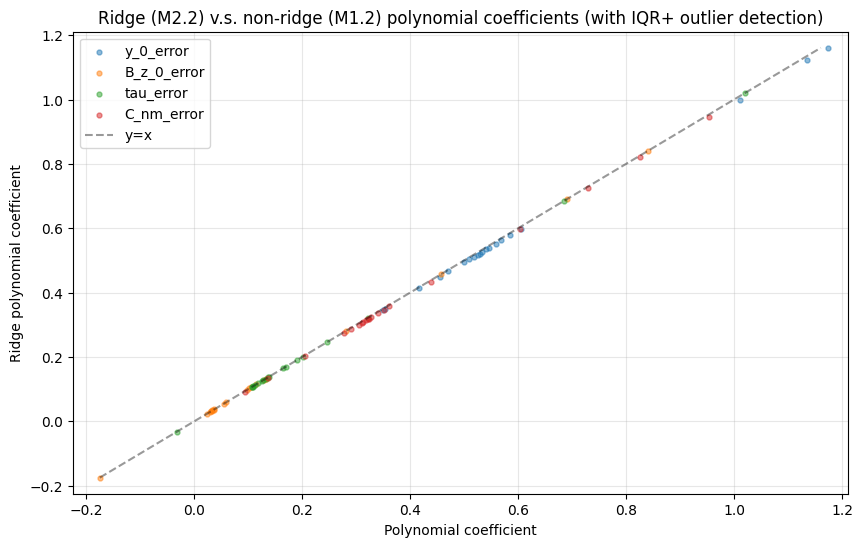

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for param in params_fitted:
    non_ridge_coefficients = polynomial_coefficients[param + "_error"]["non_ridge"]
    ridge_coefficients = polynomial_coefficients[param + "_error"]["ridge"]

    ax.scatter(non_ridge_coefficients, ridge_coefficients, marker=".", s=50, alpha=0.5, label=f"{param}_error")

ax.autoscale(enable=True, axis='both', tight=True)
y_lims = plt.ylim()
ax.set_xlim(y_lims[0] - 0.05, y_lims[1] + 0.05)
ax.set_ylim(y_lims[0] - 0.05, y_lims[1] + 0.05)
plt.plot([y_lims[0], y_lims[1]], [y_lims[0], y_lims[1]], color="black", linestyle="--", label="y=x", alpha=0.4)
plt.title(f"Ridge (M2.2) v.s. non-ridge (M1.2) polynomial coefficients (with IQR+ outlier detection)")
plt.xlabel("Polynomial coefficient")
plt.ylabel("Ridge polynomial coefficient")
plt.legend()
plt.grid(alpha=0.3)
fig.savefig("ridge_vs_non_ridge_coefficients.png", dpi=120, bbox_inches="tight")
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(10, 6))
for param in params_fitted:
    non_ridge_coefficients = polynomial_coefficients[param + "_error"]["non_ridge"]
    ridge_coefficients = polynomial_coefficients[param + "_error"]["ridge"]

    ax.scatter(non_ridge_coefficients, ridge_coefficients, marker=".", s=50, alpha=0.5, label=label_mapping[param + "_error"])

ax.autoscale(enable=True, axis='both', tight=True)
y_lims = plt.ylim()
ax.set_xlim(y_lims[0] - 0.05, y_lims[1] + 0.05)
ax.set_ylim(y_lims[0] - 0.05, y_lims[1] + 0.05)

x_line = np.linspace(y_lims[0], y_lims[1], 100)
ax.plot(x_line, x_line, color="black", linestyle="--", label="y=x", alpha=0.4)
ax.grid(which="major", alpha=0.5)
ax.grid(which="minor", alpha=0.35, linestyle=':')
ax.set_title(f"Ridge (M2.2) v.s. non-ridge (M1.2) polynomial coefficients (with IQR+ outlier detection)")
ax.set_xlabel("Polynomial coefficient")
ax.set_ylabel("Ridge polynomial coefficient")
ax.legend()

# Add zoomed inset
axins = zoomed_inset_axes(ax, zoom=3, loc="lower right")
for param in params_fitted:
    non_ridge_coefficients = polynomial_coefficients[param + "_error"]["non_ridge"]
    ridge_coefficients = polynomial_coefficients[param + "_error"]["ridge"]
    axins.scatter(non_ridge_coefficients, ridge_coefficients, marker=".", s=50, alpha=0.5)
    axins.plot(x_line, x_line, color="grey", linestyle="--", alpha=0.4)
    axins.grid(which="major", alpha=0.5)
    axins.grid(which="minor", alpha=0.35, linestyle=':')

# Set limits for the zoomed region
axins.set_xlim(0.2, 0.4)
axins.set_ylim(0.2, 0.4)
axins.set_xticks([])
axins.set_yticks([])

# Draw a box and lines linking the inset to the main plot
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

fig.savefig("ridge_vs_non_ridge_coefficients_zoomed.png", dpi=100, bbox_inches="tight")
plt.show()

# Number of experiments investigation

Filter the number of experiments and train the models.

In [ ]:
model_per_experiment_number = {}

X_all = df_agg_num_repeat[["y_0_opt", "B_z_0_opt", "tau_opt", "C_nm_opt", "noise_level"]]

for target_name in ["y_0_error", "B_z_0_error", "tau_error", "C_nm_error"]:
    y_all = df_agg_num_repeat[target_name].to_numpy()
    model_per_experiment_number[target_name] = {}
    for n_experiments in np.arange(100, 251, 10):
        df_reduced = df_agg_num_repeat.iloc[0 : n_experiments].reset_index(drop=True)
        model_per_experiment_number[target_name][n_experiments] = {}
        print(f"Fitting model for {target_name} and {n_experiments} experiments...")

        for random_state in range(1, 26):
            # Fit the model
            print(f"Random state: {random_state}")
            model_result = fit_regression_model(df=df_reduced,
                                        params_fitted=params_fitted,
                                        target_name=target_name,
                                        model_type="linear",
                                        transform_type="box-cox",
                                        outlier_detection=None, #"IQR+"
                                        verbose=False,
                                        random_state=random_state)

            X_all_scaled = model_result["X_scaler"].transform(X_all)
            X_all_ready = model_result["poly"].transform(X_all_scaled)

            y_all_pred = predict_with_model(model_result, X_all_ready)
            rmse_all = math.sqrt(mean_squared_error(y_all, y_all_pred))
            r2_all = r2_score(y_all, y_all_pred)
            model_result["stats"] = pd.concat([model_result["stats"], pd.DataFrame({"RMSE": rmse_all, "R^2": r2_all}, index=["Complete"])], axis=0)
            model_per_experiment_number[target_name][n_experiments][random_state] = model_result

Fitting model for y_0_error and 100 experiments...
Random state: 1
No outliers removed using None method
Random state: 2
No outliers removed using None method
Random state: 3
No outliers removed using None method
Random state: 4
No outliers removed using None method
Random state: 5
No outliers removed using None method
Random state: 6
No outliers removed using None method
Random state: 7
No outliers removed using None method
Random state: 8
No outliers removed using None method
Random state: 9
No outliers removed using None method
Random state: 10
No outliers removed using None method
Random state: 11
No outliers removed using None method
Random state: 12
No outliers removed using None method
Random state: 13
No outliers removed using None method
Random state: 14
No outliers removed using None method
Random state: 15
No outliers removed using None method
Random state: 16
No outliers removed using None method
Random state: 17
No outliers removed using None method
Random state: 18
No out

In [ ]:
def get_percentiles_and_mean(y: np.ndarray) -> list:
    return [np.percentile(y, 25), np.mean(y), np.percentile(y, 75)]

def compute_r2_and_rmse_per_experiment(model_per_experiment_number: dict) -> tuple:
    r2_train = {}
    r2_test = {}
    r2_all = {}
    rmse_train = {}
    rmse_test = {}
    rmse_all = {}

    for target_name in model_per_experiment_number.keys():
        r2_train_target = []
        r2_test_target = []
        r2_all_target = []
        rmse_train_target = []
        rmse_test_target = []
        rmse_all_target = []

        for n_experiments in model_per_experiment_number[target_name].keys():
            all_stats_for_this_experiment = [model_per_experiment_number[target_name][n_experiments][random_state]["stats"] for random_state in model_per_experiment_number[target_name][n_experiments]]
            
            # Train R^2
            all_r2_train = [this_stats["R^2"]["Train"] for this_stats in all_stats_for_this_experiment]
            r2_train_target.append(get_percentiles_and_mean(all_r2_train))

            # Test R^2
            all_r2_test = [this_stats["R^2"]["Test"] for this_stats in all_stats_for_this_experiment]
            r2_test_target.append(get_percentiles_and_mean(all_r2_test))

            # Complete dataset R^2
            all_r2_all = [this_model_result["stats"]["R^2"]["Complete"] for this_model_result in model_per_experiment_number[target_name][n_experiments].values()]
            r2_all_target.append(get_percentiles_and_mean(all_r2_all))

            # Train RMSE
            all_rmse_train = [this_stats["RMSE"]["Train"] for this_stats in all_stats_for_this_experiment]
            rmse_train_target.append(get_percentiles_and_mean(all_rmse_train))

            # Test RMSE
            all_rmse_test = [this_stats["RMSE"]["Test"] for this_stats in all_stats_for_this_experiment]
            rmse_test_target.append(get_percentiles_and_mean(all_rmse_test))

            # Complete dataset RMSE
            all_rmse_all = [this_model_result["stats"]["RMSE"]["Complete"] for this_model_result in model_per_experiment_number[target_name][n_experiments].values()]
            rmse_all_target.append(get_percentiles_and_mean(all_rmse_all))
 
        # Convert them to numpy arrays
        r2_train[target_name] = np.array(r2_train_target)
        r2_test[target_name] = np.array(r2_test_target)
        r2_all[target_name] = np.array(r2_all_target)
        rmse_train[target_name] = np.array(rmse_train_target)
        rmse_test[target_name] = np.array(rmse_test_target)
        rmse_all[target_name] = np.array(rmse_all_target)
    return r2_train, r2_test, r2_all, rmse_train, rmse_test, rmse_all

r2_train, r2_test, r2_all, rmse_train, rmse_test, rmse_all = compute_r2_and_rmse_per_experiment(model_per_experiment_number)


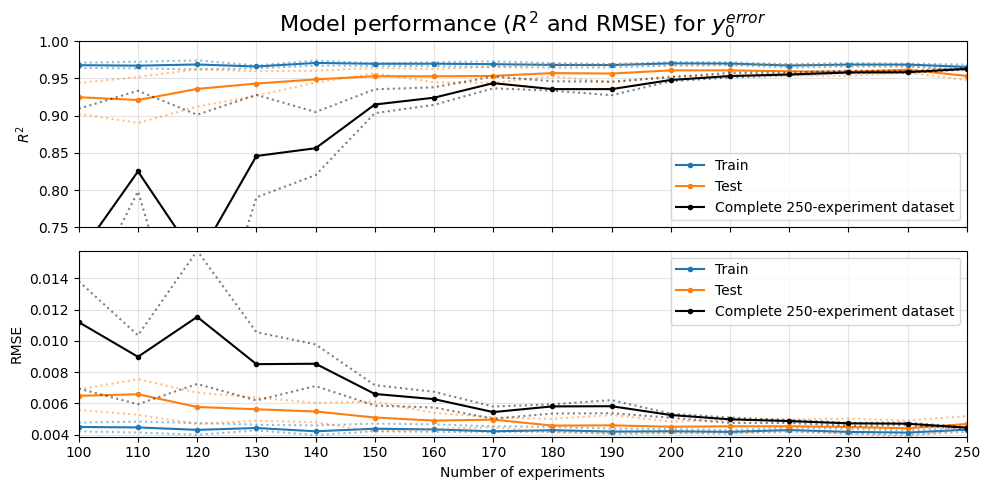

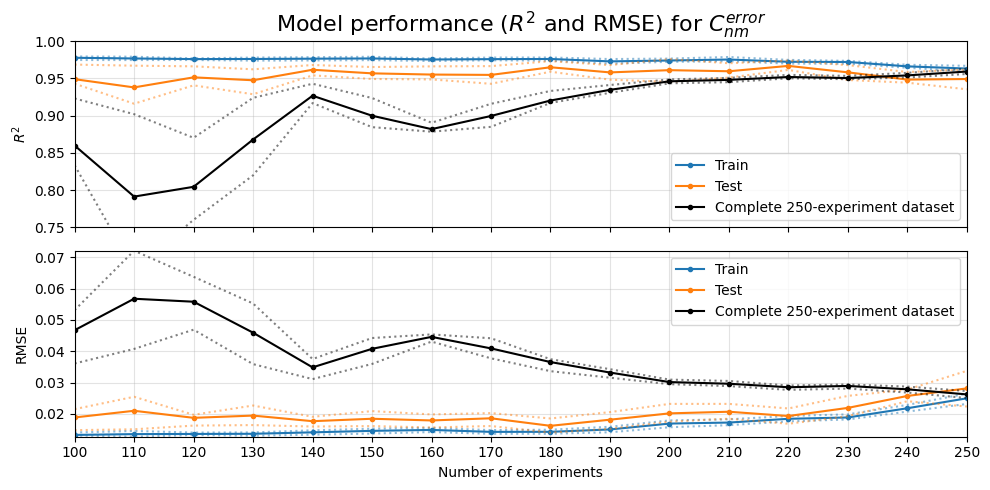

In [ ]:
for target_name in model_per_experiment_number:
    num_experiments = list(model_per_experiment_number[target_name].keys())
    r2_train_target = r2_train[target_name]
    r2_test_target = r2_test[target_name]
    r2_all_target = r2_all[target_name]
    rmse_train_target = rmse_train[target_name]
    rmse_test_target = rmse_test[target_name]
    rmse_all_target = rmse_all[target_name]

    fig, axis = plt.subplots(2, 1, figsize=(10, 5), tight_layout=True, sharex=True)
    
    # R^2 v.s. number of experiments
    ax_0 = axis[0]
    ax_0.plot(num_experiments, r2_train_target[:, 1], "-o", markersize=3, c=train_colour, label="Train")
    ax_0.plot(num_experiments, r2_train_target[:, 0], ":", alpha=0.5, c=train_colour, markersize=3)
    ax_0.plot(num_experiments, r2_train_target[:, 2], ":", alpha=0.5, c=train_colour, markersize=3)

    ax_0.plot(num_experiments, r2_test_target[:, 1], "-o", markersize=3, c=test_colour, label="Test")
    ax_0.plot(num_experiments, r2_test_target[:, 0], ":", alpha=0.5, c=test_colour, markersize=3)
    ax_0.plot(num_experiments, r2_test_target[:, 2], ":", alpha=0.5, c=test_colour, markersize=3)

    ax_0.plot(num_experiments, r2_all_target[:, 1], "-o", markersize=3, c="k", label="Complete 250-experiment dataset")
    ax_0.plot(num_experiments, r2_all_target[:, 0], ":", alpha=0.5, c="k", markersize=3)
    ax_0.plot(num_experiments, r2_all_target[:, 2], ":", alpha=0.5, c="k", markersize=3)

    ax_0.set_ylim(0.75, 1)
    ax_0.set_ylabel("$R^2$")
    #ax_0.set_title("$R^2$ vs Number of experiments")

    # RMSE v.s. number of experiments
    ax_1 = axis[1]
    ax_1.plot(num_experiments, rmse_train_target[:, 1], "-o", markersize=3, c=train_colour, label="Train")
    ax_1.plot(num_experiments, rmse_train_target[:, 0], ":", alpha=0.5, c=train_colour, markersize=3)
    ax_1.plot(num_experiments, rmse_train_target[:, 2], ":", alpha=0.5, c=train_colour, markersize=3)

    ax_1.plot(num_experiments, rmse_test_target[:, 1], "-o", markersize=3, c=test_colour, label="Test")
    ax_1.plot(num_experiments, rmse_test_target[:, 0], ":", alpha=0.5, c=test_colour, markersize=3)
    ax_1.plot(num_experiments, rmse_test_target[:, 2], ":", alpha=0.5, c=test_colour, markersize=3)

    ax_1.plot(num_experiments, rmse_all_target[:, 1], "-o", markersize=3, c="k", label="Complete 250-experiment dataset")
    ax_1.plot(num_experiments, rmse_all_target[:, 0], ":", alpha=0.5, c="k", markersize=3)
    ax_1.plot(num_experiments, rmse_all_target[:, 2], ":", alpha=0.5, c="k", markersize=3)

    ax_1.set_xlabel("Number of experiments")
    ax_1.set_ylabel("RMSE")
    #ax_1.set_title("RMSE vs Number of experiments")
    ax_1.legend()

    for ax in [ax_0, ax_1]:
        ax.set_xlim(num_experiments[0], num_experiments[-1])
        ax.grid(alpha=0.35)
        ax.set_xticks(num_experiments)
        ax.set_xticklabels(num_experiments)
        ax.legend()
    
    # Add title
    # Get the bounding boxes in figure coordinates
    bbox_left = ax_0.get_position()
    bbox_right = ax_1.get_position()

    # Compute the vertical center (y) of the row, and the horizontal center (x) between the two columns
    y = (bbox_left.y1 + bbox_left.y1) / 2
    x = (bbox_left.x0 + bbox_right.x1) / 2
    
    ax_0.set_title(f"Model performance ($R^2$ and RMSE) for {label_mapping[target_name]}", fontsize=16)
    # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    # plt.margins(0,0)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(f"model_performance_per_number_of_experiments_{target_name}.png", dpi=150, bbox_inches="tight")
    plt.show()

In [ ]:
stack_images_vertically(["model_performance_per_number_of_experiments_y_0_error.png",
                         "model_performance_per_number_of_experiments_B_z_0_error.png",
                         "model_performance_per_number_of_experiments_tau_error.png",
                         "model_performance_per_number_of_experiments_C_nm_error.png"],
                         save_file_path="model_performance_per_number_of_experiments_combined.png")

In [ ]:
this_target = "tau_error"
this_model = models[this_target]["model"]
this_scaler = models[this_target]["X_scaler"]
this_poly = models[this_target]["poly"]
this_features = models[this_target]["features"]
tau = 1.3
C_nm = 1
B_z_0 = 12
y_0 = np.linspace(0, 0.8, 51)

fig, ax = plt.subplots(1, 1)
for noise_level in [0.01, 0.025, 0.05, 0.08]:
    X_new = np.array([[y_0_i, B_z_0, tau, C_nm, noise_level] for y_0_i in y_0])
    X_new = pd.DataFrame(X_new, columns=this_features)
    
    X_new_scaled = this_scaler.transform(X_new)
    X_new_poly = this_poly.transform(X_new_scaled)
    y_pred_new = predict_with_model(this_model, X_new_poly, transform_type)
    ax.plot(y_0, y_pred_new, label=f"Noise_level={noise_level}, B_z_0={B_z_0}, tau={tau}")

ax.set_ylim(0)
ax.set_xlabel("y_0")
ax.set_ylabel(f"Predicted {this_target}")
ax.set_title(f"Predicted {this_target} vs y_0")
plt.legend()
plt.show()

KeyError: 'tau_error'

In [77]:
def sweep_2d(x1: ParameterRange, x2: ParameterRange, x_fixed: dict[str, float], model_result: dict, label_mapping: dict[str, str], x_slice: ParameterSlice | None = None, title="", save_name: str | None = None) -> None:
    target_name = model_result["target_name"]

    # Predict over a grid
    n = 31
    y_0_range = np.linspace(0, 0.8, n)
    tau_range = np.linspace(0.5, 2, n)
    a_grid, b_grid = np.meshgrid(y_0_range, tau_range)
    X_grid_raw = np.column_stack((a_grid.ravel(), b_grid.ravel()))
    X_grid_raw = pd.DataFrame(X_grid_raw, columns=[x1.name, x2.name])

    if x_slice is None:
        x_slice_name = list(x_fixed.keys())[0]
        x_slice = ParameterSlice(range=[x_fixed[x_slice_name]], name=x_slice_name)
        x_fixed = {k: v for k, v in x_fixed.items() if k != x_slice.name}

    X_grids = list()
    for slice_value in x_slice.range:
        X_grid_slice = X_grid_raw.copy()
        X_grid_slice[x_slice.name] = slice_value
        for fixed_param, fixed_value in x_fixed.items():
            X_grid_slice[fixed_param] = fixed_value
        X_grids.append(X_grid_slice)

    fig = plt.figure(figsize=(12, 8), tight_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    for X_grid in X_grids:
        for fixed_param, fixed_value in x_fixed.items():
            X_grid[fixed_param] = fixed_value

        # Reorder the columns to match the model's input
        cols = X_grid.columns.tolist()
        ordered = model_result["features"]
        new = [item for item in ordered if item in cols]
        X_grid = X_grid[new]

        X_grid_scaled = model_result["X_scaler"].transform(X_grid)
        if "poly" in model_result:
            X_ready = model_result["poly"].transform(X_grid_scaled)
        else:
            X_ready = X_grid_scaled

        y_pred = predict_with_model(model_result, X_ready).reshape(n, n)

        # Plot
        ax.plot_surface(a_grid, b_grid, y_pred, cmap="coolwarm")

    ax.set_xlabel(f"{label_mapping[x1.name]}")
    ax.set_ylabel(f"{label_mapping[x2.name]}")
    ax.set_zlabel(f"{label_mapping[target_name]}")
    ax.set_zlim(0)
    ax.set_box_aspect(None, zoom=0.95)
    plt.title(f"Error surface for {label_mapping[target_name]} {title}")

    if save_name is not None:
        plt.savefig(save_name, dpi=80, bbox_inches="tight")
    plt.show()

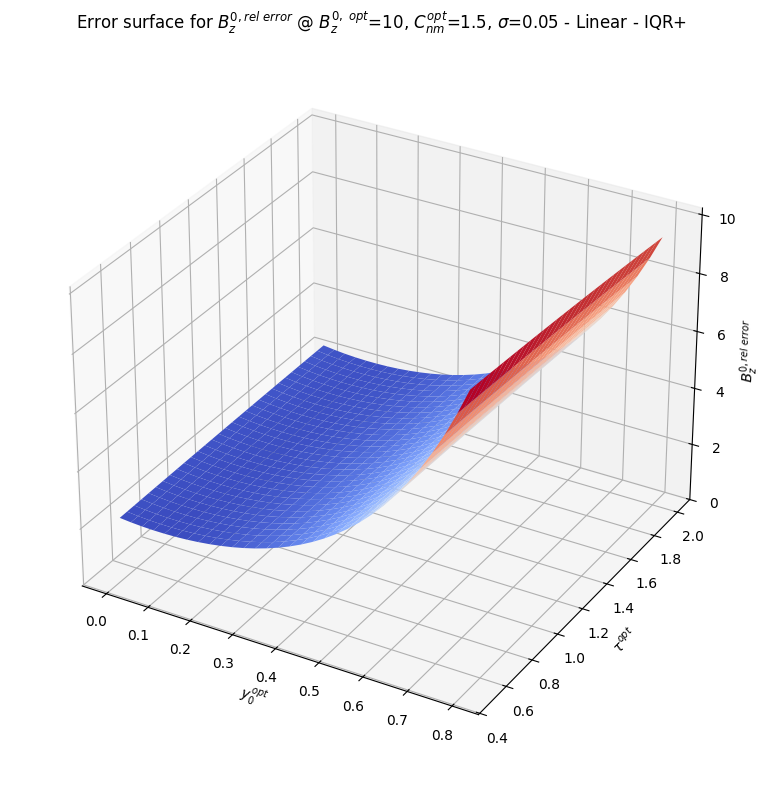

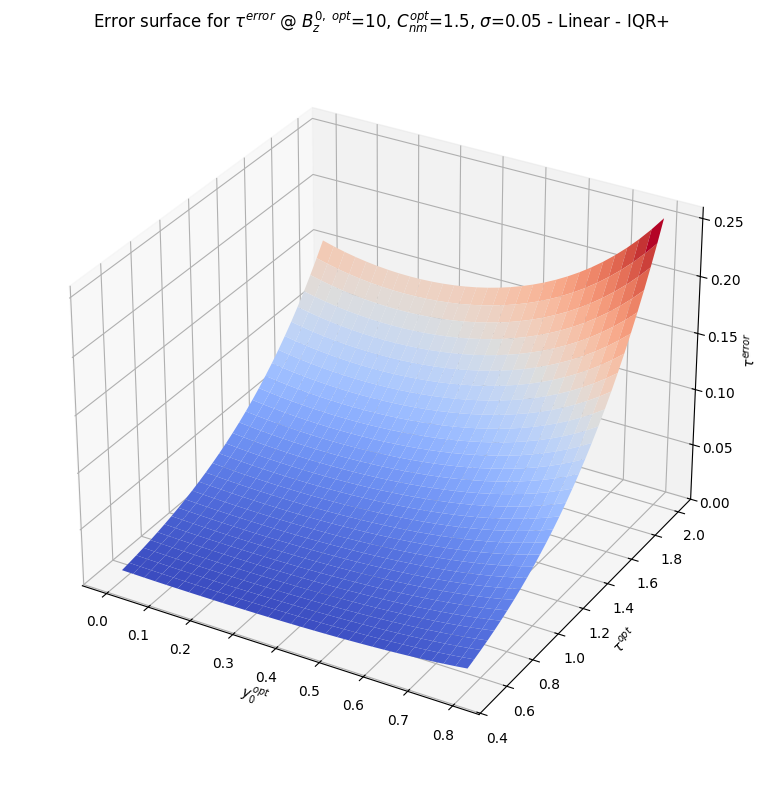

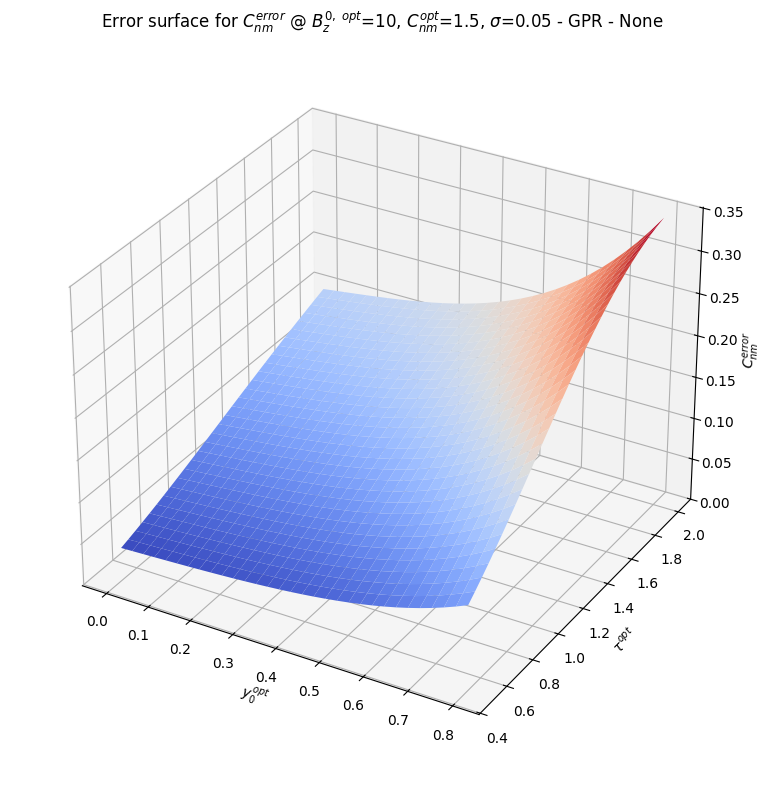

In [78]:
from MagneticFluxRopeModels.MFRMetaModel import ParameterRange#, sweep_2d

title = r"@ $B_z^{0,\ opt}$=10, $C_{nm}^{opt}$=1.5, $\sigma$=0.05"

sweep_2d(x1=ParameterRange(0, 0.9, "y_0_opt"),
         x2=ParameterRange(0.3, 2, "tau_opt"),
         x_fixed={"B_z_0_opt": 10, "C_nm_opt": 1.5, "noise_level": 0.05},
         model_result=all_models["linear"]["box-cox"]["IQR+"]["y_0_error"],
         label_mapping=label_mapping,
         title=title + " - Linear - IQR+",
         save_name="surface_y_0.png")

sweep_2d(x1=ParameterRange(0, 0.9, "y_0_opt"),
         x2=ParameterRange(0.3, 2, "tau_opt"),
         x_fixed={"B_z_0_opt": 10, "C_nm_opt": 1.5, "noise_level": 0.05},
         model_result=all_models["linear"]["box-cox"]["IQR+"]["B_z_0_rel_error"],
         label_mapping=label_mapping,
         title=title + " - Linear - IQR+",
         save_name="surface_B_z_0.png")

sweep_2d(x1=ParameterRange(0, 0.9, "y_0_opt"),
         x2=ParameterRange(0.3, 2, "tau_opt"),
         x_fixed={"B_z_0_opt": 10, "C_nm_opt": 1.5, "noise_level": 0.05},
         model_result=all_models["linear"]["box-cox"]["IQR+"]["tau_error"],
         label_mapping=label_mapping,
         title=title + " - Linear - IQR+",
         save_name="surface_tau.png")

sweep_2d(x1=ParameterRange(0, 0.9, "y_0_opt"),
         x2=ParameterRange(0.3, 2, "tau_opt"),
         x_fixed={"B_z_0_opt": 10, "C_nm_opt": 1.5, "noise_level": 0.05},
         model_result=all_models["gpr"]["box-cox"][None]["C_nm_error"],
         label_mapping=label_mapping,
         title=title + " - GPR - None",
         save_name="surface_C_nm.png")

In [79]:
def stack_images_vertically(images: list[str], save_file_path: str | None = None) -> None:
    # Load all of the images
    images = [Image.open(image_path) if isinstance(image_path, str) else image_path for image_path in images]

    # Assume all images are the same size
    width, height = images[0].size

    # Create a new blank image with size to hold a 2x2 grid
    combined = Image.new("RGBA", (width, len(images) * height))

    # Paste the 4 images into the correct positions
    for imgage_idx, image in enumerate(images):
        combined.paste(image, (0, imgage_idx*height))

    if save_file_path is not None:
        # Save the combined image
        combined.save(save_file_path)
    return combined

In [80]:
def stack_images_horizontally(images: list[str], save_file_path: str | None = None) -> None:
    # Load all of the images
    images = [Image.open(image_path) if isinstance(image_path, str) else image_path for image_path in images]

    # Assume all images are the same size
    width, height = images[0].size

    # Create a new blank image with size to hold a 2x2 grid
    combined = Image.new("RGBA", (len(images) * width, height))

    # Paste the 4 images into the correct positions
    for imgage_idx, image in enumerate(images):
        combined.paste(image, (imgage_idx*width, 0))

    if save_file_path is not None:
        # Save the combined image
        combined.save(save_file_path)
    return combined

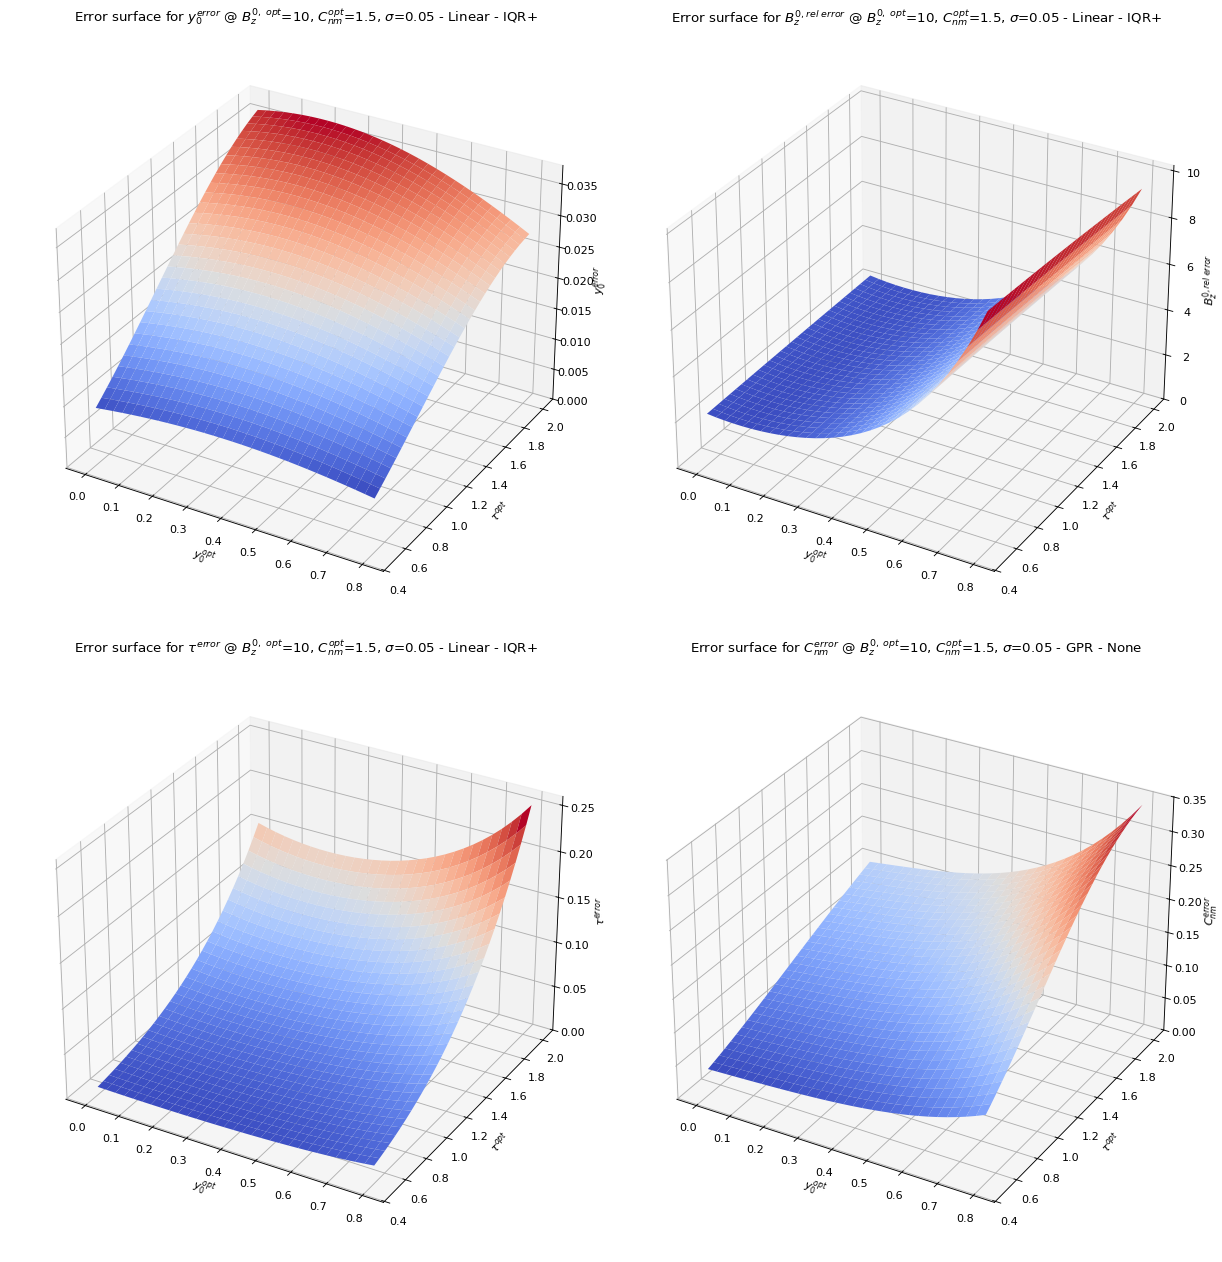

In [81]:
stack_images_horizontally(["surface_y_0.png", "surface_B_z_0.png"], save_file_path="surface_y_0_B_z_0.png")
stack_images_horizontally(["surface_tau.png", "surface_C_nm.png"], save_file_path="surface_tau_C_nm.png")
stack_images_vertically(["surface_y_0_B_z_0.png", "surface_tau_C_nm.png"], save_file_path="metamodel-surfaces.png")

In [ ]:
df_agg_num_repeat[df_agg_num_repeat["B_z_0"]==10]